In [40]:
from collections import defaultdict
import copy
import itertools as it
import json
import os
import pickle
import sys
import time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import cv2
import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import collections as mc
import networkx as nximport
import numpy as np
from scipy import stats
import torch
import vizdoom as vzd

from rlpyt.envs.vizdoom.vizdoom_env import VizDoomEnv
import rlpyt.models.resnet as resnet
from rlpyt.models.dqn.dsr.dsr_model import DsrModel
from rlpyt.models.dqn.dsr.tcf_model import FixedVizDoomModel
from rlpyt.utils.seed import make_seed, get_seed

vzd_dir = 'vizdoom_data'
import keras
import tensorflow as tf

os.environ['CUDA_VISIBLE_DEVICES'] = '2'
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.25
keras.backend.tensorflow_backend.set_session(tf.Session(config=config))

from itertools import tee, islice
def nwise(iterable, n=2):                                                      
    iters = tee(iterable, n)                                                     
    for i, it in enumerate(iters):                                               
        next(islice(it, i, i), None)                                               
    return zip(*iters)

np.random.seed(333)
device = torch.device('cuda', index=0)

In [832]:
plt.style.use(['default'])

In [801]:
for i in range(10):
    print(make_seed())

5939
7363
6294
8179
8627
3587
461
5105
1432
4778


In [41]:
def plot_topdown(env, fig, linewidth=2):
    env.reset()
    state = env.state

    for s in state.sectors:
        # Plot sector on map
        for l in s.lines:
            if l.is_blocking:
                fig.plot([l.x1, l.x2], [l.y1, l.y2], color='black', linewidth=linewidth)

def get_s_features(state, feature_model, dsr_model, norm=True, numpy=True):
    features = feature_model(torch.Tensor(state).unsqueeze(0).to(device))
    s_features = dsr_model(features, mode='dsr')
    if norm:
        s_features = torch.mean(s_features, dim=1)
        s_features = s_features / torch.norm(s_features, p=2, dim=1, keepdim=True)
    if numpy:
        s_features = s_features.detach().cpu().numpy().squeeze()
    return s_features

## Visualization: local policy success rate over time

In [750]:
eval_dir = '../data/local/20201001/vizdoom/run_9/'
SUCCESS_RATE_EVAL_DIR = '../data/visualize/run_8'

In [100]:
config = json.load(open(os.path.join(eval_dir, 'params.json')))
config['env']['config'] = '../' + config['env']['config']
config['agent']['feature_model_kwargs']['fixed_weights_path'] = '../' + \
    config['agent']['feature_model_kwargs']['fixed_weights_path'] 

In [101]:
with open('../experiments/configs/2589-small-fixed-start-goal-pairs.json') as f:
    goal_pairs = json.load(f)

In [102]:
env = VizDoomEnv(**config['env'])

In [512]:
itr = 200000 - 1

In [441]:
feature_model = FixedVizDoomModel(**config['agent']['feature_model_kwargs'])
feature_model.to(device)
weights = torch.load(os.path.join(eval_dir, 'itr_{}.pkl'.format(itr)), map_location=device)
dsr_model = DsrModel(env.observation_space.shape,
                     env.action_space.n, **config['agent']['model_kwargs']).to(device)
dsr_model.load_state_dict(weights['agent_state_dict']['model'])
dsr_model.eval()
dsr_model.to(device)

DsrModel(
  (dsr): MlpModel(
    (model): Sequential(
      (0): Linear(in_features=2048, out_features=2048, bias=True)
      (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=2048, out_features=1024, bias=True)
      (4): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Linear(in_features=1024, out_features=14336, bias=True)
    )
  )
  (q_estimate): Linear(in_features=2048, out_features=1, bias=True)
)

### Visualizing Subgoal Policy Success Rate

In [751]:
def get_subgoal_data(itr, success_rate_threshold, attempts_threshold, num_landmarks=None):
    itr -= 1
    landmarks = np.load(os.path.join(SUCCESS_RATE_EVAL_DIR, 'landmarks_itr_{}.npz'.format(itr)))
    
    positions = landmarks['positions']
    N = len(positions)
    
    if num_landmarks is not None:
        limit = num_landmarks
    else:
        limit = N

    edge_subgoal_steps = landmarks['edge_subgoal_steps'][:limit, :limit]
    edge_subgoal_failures = landmarks['edge_subgoal_failures'][:limit, :limit]
    edge_subgoal_successes = landmarks['edge_subgoal_successes'][:limit, :limit]
    edge_subgoal_attempts = landmarks['edge_subgoal_attempts'][:limit, :limit]
    subgoal_successes = edge_subgoal_successes + np.tril(edge_subgoal_successes, -1).T + np.triu(edge_subgoal_successes, 1).T
    subgoal_attempts = edge_subgoal_attempts + np.tril(edge_subgoal_attempts, -1).T + np.triu(edge_subgoal_attempts, 1).T

    subgoal_steps = edge_subgoal_steps + np.tril(edge_subgoal_steps, -1).T + np.triu(edge_subgoal_steps, 1).T
    subgoal_failures = edge_subgoal_failures + np.tril(edge_subgoal_failures, -1).T + np.triu(edge_subgoal_failures, 1).T

    average_subgoal_steps = subgoal_steps / np.clip(subgoal_successes, 1, None)

    print('Number of landmarks:', N)

    failure_edges = np.argwhere(subgoal_failures > 0)
    print('Number of failure edges:', failure_edges.shape[0])
    subgoal_success_edges = np.argwhere(subgoal_successes > 0)
    print('Number of subgoal edges:', subgoal_success_edges.shape[0])
    subgoal_attempt_edges = np.argwhere(subgoal_attempts > 0)
    print('Number of attempt edges:', subgoal_attempt_edges.shape[0])
    
    subgoal_success_rate = subgoal_successes / np.clip(subgoal_attempts, 1, None)
    
    subgoal_edges = np.argwhere((subgoal_success_rate > success_rate_threshold) & (subgoal_attempts > attempts_threshold))
    failed_subgoal_edges = np.argwhere((subgoal_success_rate > 0) & (subgoal_success_rate <= success_rate_threshold) \
                                       & (subgoal_attempts > attempts_threshold))
    
    subgoal_edge_rate = subgoal_success_rate[subgoal_edges[:, 0], subgoal_edges[:, 1]]
    
    positions = positions[:limit]
    
    return positions, subgoal_edges, failed_subgoal_edges, subgoal_edge_rate, N

Number of landmarks: 282
Number of failure edges: 0
Number of subgoal edges: 134
Number of attempt edges: 162
Number of landmarks: 481
Number of failure edges: 0
Number of subgoal edges: 516
Number of attempt edges: 588


<Figure size 640x480 with 0 Axes>

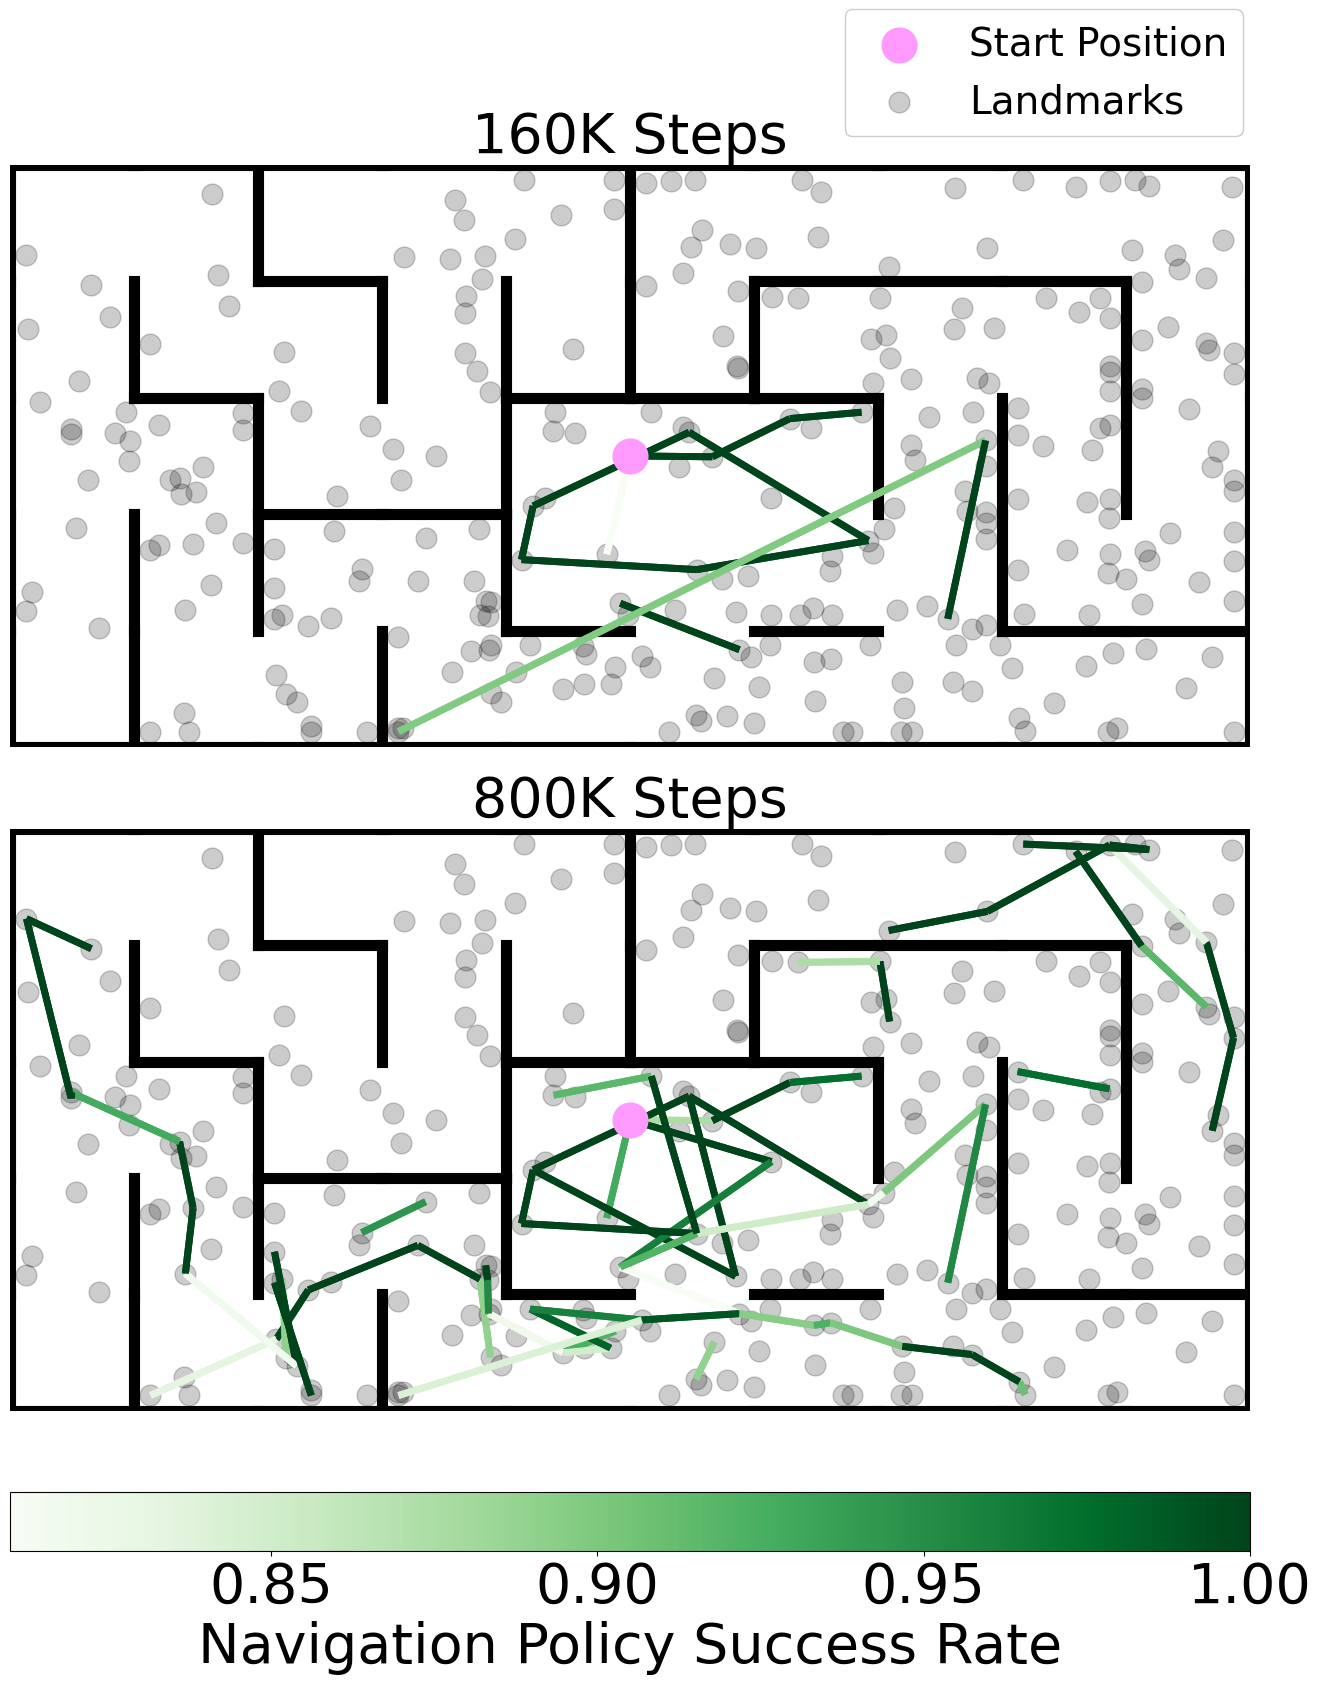

In [834]:
plt.set_cmap('Greens')
gridspec = {'height_ratios': [1, 1, 0.1]}
fig, ax = plt.subplots(3, 1, figsize=(16, 18), gridspec_kw = gridspec)
plt.subplots_adjust(hspace=0.2)

num_landmarks = None

for i, itr in enumerate([20000, 100000]):
    positions, subgoal_edges, failed_subgoal_edges, subgoal_edge_rate, num_landmarks = get_subgoal_data(itr, 0.80, 5, num_landmarks)
    starts = positions[subgoal_edges[:, 0], :2]
    ends = positions[subgoal_edges[:, 1], :2]
    lc = mc.LineCollection(list(zip(starts, ends)),
                           linewidths=5, linestyle='solid', zorder=100)
    lc.set_array(subgoal_edge_rate)
    ax[i].add_collection(lc)
    ax[i].axis('off')

    ax[i].set_xlim(env.min_x, env.max_x)
    ax[i].set_ylim(env.min_y, env.max_y)
    plot_topdown(env, ax[i], linewidth=8)
    ax[i].set_title('{:.0f}K Steps'.format(itr * 8 / 1000), fontsize=40)
    ax[i].scatter(*env.start_info[1][:2], s=625, color=START_COLOR, label='Start Position', zorder=100)
    ax[i].scatter(positions[:, 0], positions[:, 1], s=225, color='black', edgecolor='black', alpha=0.2, label='Landmarks')

ax[0].legend(loc='upper right', fontsize=28, bbox_to_anchor=(1.01, 1.3), facecolor='white', framealpha=1)
    
cbar = plt.colorbar(lc, cax=ax[2], orientation='horizontal')
cbar.ax.tick_params(labelsize=40)  
cbar.set_label('Navigation Policy Success Rate', fontsize=40)
plt.savefig('/mnt/brain1/scratch/choang/icml/figures/local-policy-success-rate.png', bbox_inches='tight')

In [191]:
# subgoal_edges = np.argwhere((average_subgoal_steps > 0) & (average_subgoal_steps < 20))
# failed_subgoal_edges = np.argwhere((average_subgoal_steps >= 20))

# subgoal_edge_steps = average_subgoal_steps[subgoal_edges[:, 0], subgoal_edges[:, 1]]
# values = np.interp(subgoal_edge_steps, (subgoal_edge_steps.min(), subgoal_edge_steps.max()), (0, 1))
# values = stats.rankdata(subgoal_edge_steps, 'average') / len(subgoal_edge_steps)

In [1026]:
def get_path(goal_pair, feature_model, dsr_model, graph):
    start_pos, goal_pos = goal_pair
    start_state, start_pos = env.get_obs_at(start_pos, idx=3)
    goal_state, goal_pos = env.get_obs_at(goal_pos, idx=-1)
    start_sf = get_s_features(start_state, feature_model, dsr_model)
    goal_sf = get_s_features(goal_state, feature_model, dsr_model)

    start_sim = np.matmul(norm_dsr, start_sf).max()
    start_landmark = np.matmul(norm_dsr, start_sf).argmax()

    goal_sim = np.matmul(norm_dsr, goal_sf.T).max()
    goal_landmark = np.matmul(norm_dsr, goal_sf.T).argmax()

    print('SF start:', start_landmark)
    print('SF goal:', goal_landmark)
    
    graph = nx.from_numpy_array(edge_weights)
    has_path = nx.has_path(graph, start_landmark, goal_landmark)
    if has_path:
        path = nx.shortest_path(graph, start_landmark, goal_landmark, weight='weight')
        print('Found path:', path)
    else:
        path = None
        print('No path from {} to {}'.format(start_landmark, goal_landmark))
    
    return start_pos, goal_pos, path

In [1308]:
itr = 200000 - 1
landmarks = np.load(os.path.join(eval_dir, 'landmarks_itr_{}.npz'.format(itr)))

positions = landmarks['positions']
N = len(positions)

dsr = landmarks['dsr']
norm_dsr = dsr / np.linalg.norm(dsr, ord=2, axis=1, keepdims=True)
dsr_sim = np.matmul(norm_dsr, norm_dsr.T)
dsr_sim[np.eye(N, dtype=bool)] = -1
features = landmarks['features']
norm_features = features / np.linalg.norm(features, ord=2, axis=1, keepdims=True)
feature_sim = np.matmul(norm_features, norm_features.T)

edge_random_steps = landmarks['edge_random_steps']
edge_random_transitions = landmarks['edge_random_transitions']
edge_subgoal_steps = landmarks['edge_subgoal_steps']
edge_subgoal_failures = landmarks['edge_subgoal_failures']
if 'edge_subgoal_successes' in landmarks:
    edge_subgoal_successes = landmarks['edge_subgoal_successes']
    edge_subgoal_attempts = landmarks['edge_subgoal_attempts']
    subgoal_successes = edge_subgoal_successes + np.tril(edge_subgoal_successes, -1).T + np.triu(edge_subgoal_successes, 1).T
    subgoal_attempts = edge_subgoal_attempts + np.tril(edge_subgoal_attempts, -1).T + np.triu(edge_subgoal_attempts, 1).T
    
random_steps = edge_random_steps + np.tril(edge_random_steps, -1).T
random_transitions = edge_random_transitions + np.tril(edge_random_transitions, -1).T + np.triu(edge_random_transitions, 1).T

subgoal_steps = edge_subgoal_steps + np.tril(edge_subgoal_steps, -1).T + np.triu(edge_subgoal_steps, 1).T
subgoal_failures = edge_subgoal_failures + np.tril(edge_subgoal_failures, -1).T + np.triu(edge_subgoal_failures, 1).T

average_random_steps = random_steps / np.clip(random_transitions, 1, None)

if 'edge_subgoal_successes' in landmarks:
    average_subgoal_steps = subgoal_steps / np.clip(subgoal_successes, 1, None)


transitions = random_transitions #  + subgoal_successes

print('Number of landmarks:', N)
print('Number of non-zero random transitions:', np.argwhere(random_transitions > 0).shape[0])
percentile = 50
threshold = np.percentile(random_transitions[random_transitions > 0], percentile)
print('{} percentile of random transitions:'.format(percentile), 
      threshold)

temporally_nearby_threshold = max(N // 10, 10)
temporally_nearby_landmarks = np.tril(np.triu(np.ones((N), dtype=bool), 1), temporally_nearby_threshold)
temporally_nearby_landmarks += temporally_nearby_landmarks.T


failure_edges = np.argwhere(subgoal_failures > 0)
print('Number of failure edges:', failure_edges.shape[0])
if 'edge_subgoal_successes' in landmarks:
    subgoal_success_edges = np.argwhere(subgoal_successes > 0)
    print('Number of subgoal edges:', subgoal_success_edges.shape[0])
    subgoal_attempt_edges = np.argwhere(subgoal_attempts > 0)
    print('Number of attempt edges:', subgoal_attempt_edges.shape[0])

true_edges = random_transitions >= threshold
true_edges = temporally_nearby_landmarks & true_edges

# k = 5
# nearest_neighbors = np.argpartition(true_edges * random_transitions, -k)[:, -k:]
# k_filter = np.zeros((N, N), dtype=bool)
# idx = np.vstack([np.arange(N)] * k).T
# k_filter[idx, nearest_neighbors] = True
# true_edges = k_filter & true_edges

true_edges = (subgoal_failures <= 1) & true_edges

edge_weights = true_edges * (np.exp(-1 * random_transitions))
edge_weights[(edge_weights > 0) & (subgoal_failures > 1)] = \
    edge_weights[(edge_weights > 0) & (subgoal_failures >1)] + 5000

print('Number of edges:', np.sum(edge_weights > 0))
edges = np.argwhere(edge_weights > 0)

Number of landmarks: 517
Number of non-zero random transitions: 16256
50 percentile of random transitions: 3.0
Number of failure edges: 714
Number of edges: 3212


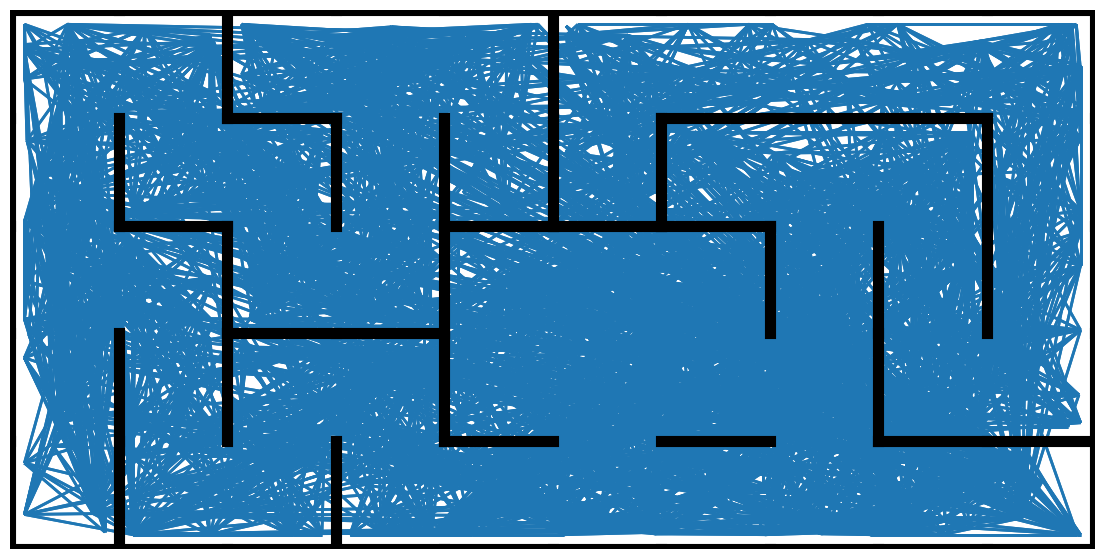

In [1306]:
starts = positions[edges[:, 0], :2]
ends = positions[edges[:, 1], :2]
lc = mc.LineCollection(list(zip(starts, ends)),
                       linewidths=2)
fig, ax = plt.subplots(figsize=(14, 7))
plt.tick_params(labelsize=14)
ax.set_xlim(env.min_x, env.max_x)
ax.set_ylim(env.min_y, env.max_y)
plot_topdown(env, ax, linewidth=8)
ax.add_collection(lc)
plt.axis('off')
# plt.savefig('/mnt/brain1/scratch/choang/icml/figures/no-filtered-landmarks.png')

In [514]:
def get_visitations_percentile(itr):
    landmarks = np.load(os.path.join(eval_dir, 'landmarks_itr_{}.npz'.format(itr)))

    positions = landmarks['positions']
    N = len(positions)

    dsr = landmarks['dsr']
    norm_dsr = dsr / np.linalg.norm(dsr, ord=2, axis=1, keepdims=True)
    dsr_sim = np.matmul(norm_dsr, norm_dsr.T)
    dsr_sim[np.eye(N, dtype=bool)] = -1
    features = landmarks['features']
    norm_features = features / np.linalg.norm(features, ord=2, axis=1, keepdims=True)
    feature_sim = np.matmul(norm_features, norm_features.T)

    edge_random_steps = landmarks['edge_random_steps']
    edge_random_transitions = landmarks['edge_random_transitions']
    edge_subgoal_steps = landmarks['edge_subgoal_steps']
    edge_subgoal_failures = landmarks['edge_subgoal_failures']
    if 'edge_subgoal_successes' in landmarks:
        edge_subgoal_successes = landmarks['edge_subgoal_successes']
        edge_subgoal_attempts = landmarks['edge_subgoal_attempts']
        subgoal_successes = edge_subgoal_successes + np.tril(edge_subgoal_successes, -1).T + np.triu(edge_subgoal_successes, 1).T
        subgoal_attempts = edge_subgoal_attempts + np.tril(edge_subgoal_attempts, -1).T + np.triu(edge_subgoal_attempts, 1).T

    random_steps = edge_random_steps + np.tril(edge_random_steps, -1).T
    random_transitions = edge_random_transitions + np.tril(edge_random_transitions, -1).T + np.triu(edge_random_transitions, 1).T

    subgoal_steps = edge_subgoal_steps + np.tril(edge_subgoal_steps, -1).T + np.triu(edge_subgoal_steps, 1).T
    subgoal_failures = edge_subgoal_failures + np.tril(edge_subgoal_failures, -1).T + np.triu(edge_subgoal_failures, 1).T

    average_random_steps = random_steps / np.clip(random_transitions, 1, None)

    if 'edge_subgoal_successes' in landmarks:
        average_subgoal_steps = subgoal_steps / np.clip(subgoal_successes, 1, None)


    transitions = random_transitions #  + subgoal_successes

    print('Number of landmarks:', N)
    print('Number of non-zero random transitions:', np.argwhere(random_transitions > 0).shape[0])
    percentile = 50
    threshold = np.percentile(random_transitions[random_transitions > 0], percentile)
    print('{} percentile of random transitions:'.format(percentile), 
          threshold)

    temporally_nearby_threshold = max(N // 10, 10)
    temporally_nearby_landmarks = np.tril(np.triu(np.ones((N), dtype=bool), 1), temporally_nearby_threshold)
    temporally_nearby_landmarks += temporally_nearby_landmarks.T


    failure_edges = np.argwhere(subgoal_failures > 0)
    print('Number of failure edges:', failure_edges.shape[0])
    if 'edge_subgoal_successes' in landmarks:
        subgoal_success_edges = np.argwhere(subgoal_successes > 0)
        print('Number of subgoal edges:', subgoal_success_edges.shape[0])
        subgoal_attempt_edges = np.argwhere(subgoal_attempts > 0)
        print('Number of attempt edges:', subgoal_attempt_edges.shape[0])

    true_edges = random_transitions >= threshold
    true_edges = temporally_nearby_landmarks & true_edges

    # k = 5
    # nearest_neighbors = np.argpartition(true_edges * random_transitions, -k)[:, -k:]
    # k_filter = np.zeros((N, N), dtype=bool)
    # idx = np.vstack([np.arange(N)] * k).T
    # k_filter[idx, nearest_neighbors] = True
    # true_edges = k_filter & true_edges

    # true_edges = (subgoal_failures <= 1) & true_edges

    edge_weights = true_edges * (np.exp(-1 * random_transitions))
    edge_weights[(edge_weights > 0) & (subgoal_failures > 1)] = \
        edge_weights[(edge_weights > 0) & (subgoal_failures >1)] + 5000

    print('Number of edges:', np.sum(edge_weights > 0))
    edges = np.argwhere(edge_weights > 0)
    visitations = np.sum(random_transitions, axis=0)
    visitations_percentile = stats.rankdata(visitations, 'average') / len(visitations)
    return positions, visitations_percentile

Number of landmarks: 200
Number of non-zero random transitions: 1442
50 percentile of random transitions: 1.0
Number of failure edges: 12
Number of edges: 632
Number of landmarks: 510
Number of non-zero random transitions: 14376
50 percentile of random transitions: 2.0
Number of failure edges: 610
Number of edges: 3622


<Figure size 640x480 with 0 Axes>

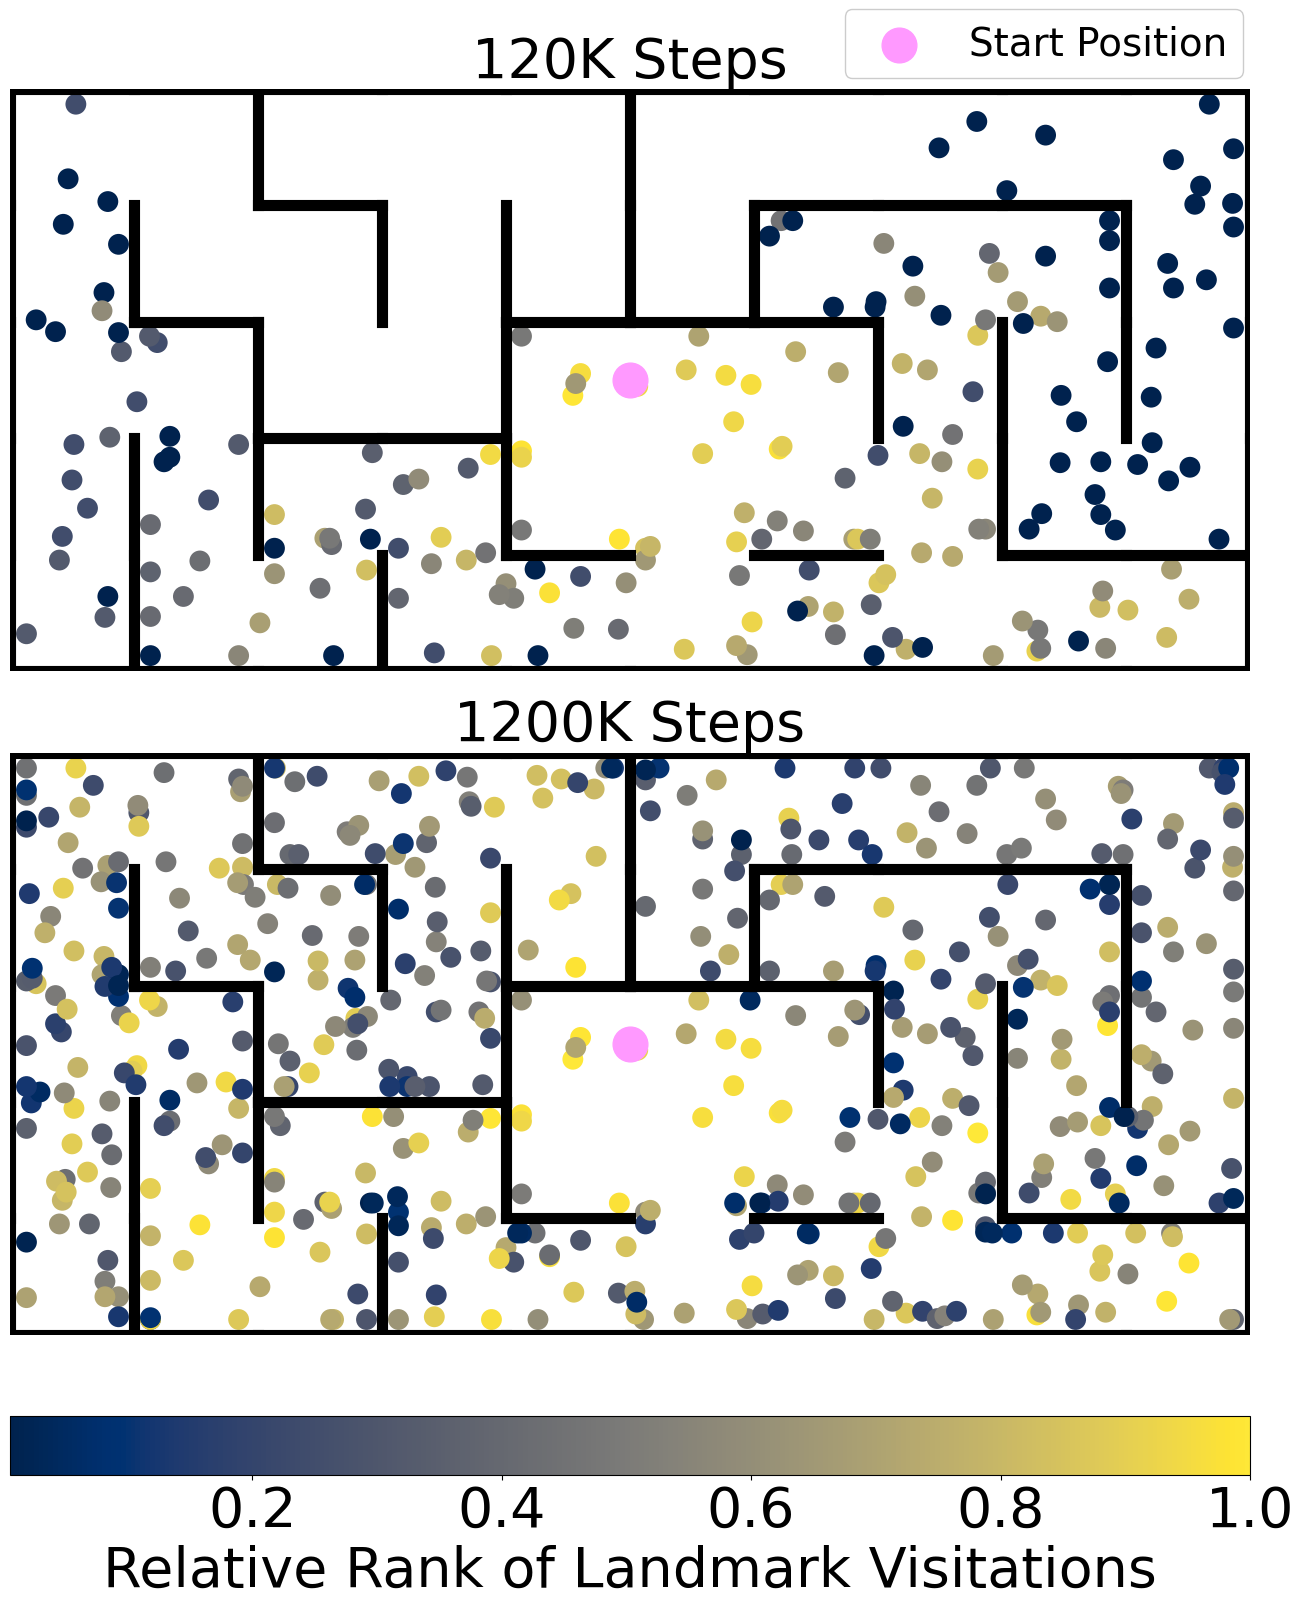

In [835]:
plt.set_cmap('cividis')
gridspec = {'height_ratios': [1, 1, 0.1]}
fig, ax = plt.subplots(3, 1, figsize=(16, 18), gridspec_kw = gridspec)
plt.subplots_adjust(hspace=0.2)

for i, itr in enumerate([15000, 150000]):
    ax[i].axis('off')

    ax[i].set_xlim(env.min_x, env.max_x)
    ax[i].set_ylim(env.min_y, env.max_y)
    plot_topdown(env, ax[i], linewidth=8)
    ax[i].set_title('{:.0f}K Steps'.format(itr * 8 / 1000), fontsize=40)
    
    positions, visitations_percentile = get_visitations_percentile(itr - 1)
    
    scatter = ax[i].scatter(positions[:, 0], positions[:, 1], c=visitations_percentile, s=225, edgecolor='none')
    ax[i].scatter(*env.start_info[1][:2], s=625, color=START_COLOR, label='Start Position')


ax[0].legend(loc='upper right', fontsize=28, bbox_to_anchor=(1.01, 1.17), facecolor='white', framealpha=1)

cbar = plt.colorbar(scatter, cax=ax[2], orientation='horizontal', pad=0.20)
cbar.ax.tick_params(labelsize=40) 
cbar.set_label('Relative Rank of Landmark Visitations', fontsize=40)
plt.savefig('/mnt/brain1/scratch/choang/icml/figures/successor-landmarks-percentile-visitations.png', bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

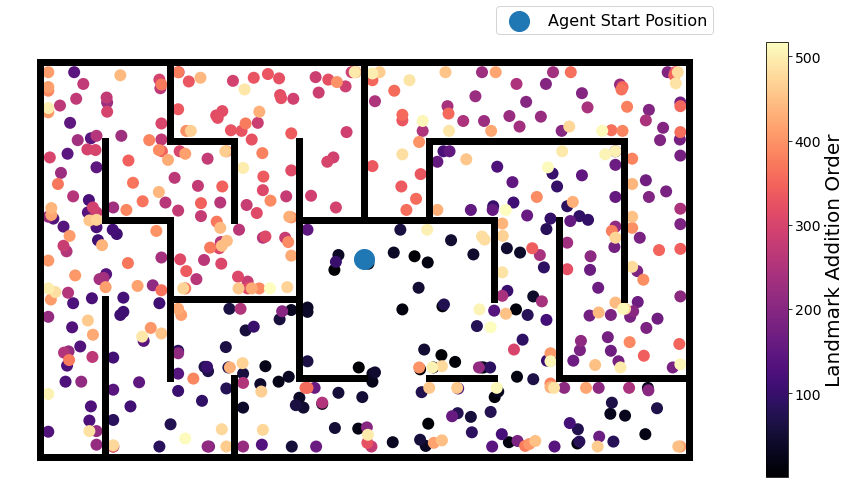

In [88]:
plt.set_cmap('magma')
fig = plt.figure(figsize=(16, 8))
plt.axis('off')

plot_topdown(env, plt, 7)

plt.scatter(positions[:, 0], positions[:, 1], c=np.arange(N), s=144, edgecolor='none')
plt.scatter(*env.start_info[1][:2], s=400, color='tab:blue', label='Agent Start Position')
plt.legend(loc='upper right', fontsize=16, bbox_to_anchor=(1, 1.1))
cbar = plt.colorbar()
plt.clim(1, N)
cbar.ax.tick_params(labelsize=14) 
cbar.set_label('Landmark Addition Order', fontsize=20)
plt.savefig('/mnt/brain1/scratch/choang/icml/figures/successor-landmarks-landmark-add-order.png')

## Intro Figure

In [528]:
import networkx as nx

In [529]:
graph = nx.from_numpy_array(edge_weights, create_using=nx.DiGraph)

In [597]:
goal_pair = [[160, -50, 0], [535, 85, 270]]  # goal_pairs['hard'][4]
good_start, good_goal, good_path = get_path(goal_pair, feature_model, dsr_model, graph)

SF start: 36
SF goal: 96
Found path: [36, 74, 77, 79, 81, 126, 96]


In [623]:
exploration_path = good_path[:4]
exploration_landmarks = exploration_path + random_transitions[exploration_path].argmax(axis=1).tolist()[:-1]
cross_exploration_landmarks = np.array(list(it.product(exploration_landmarks, exploration_landmarks)))
exploration_edges = np.zeros((N, N), dtype=bool)
exploration_edges[cross_exploration_landmarks[:, 0], cross_exploration_landmarks[:, 1]] = 1
exploration_edges = edge_weights.copy() * exploration_edges
exploration_edges = np.argwhere(exploration_edges > 0)

In [624]:
# 1. make exploration path to a closer landmark
# 2. make added landmark be one that is existing to the path to the goal
# 3. current path is the testing path
# 4. add neary landmarks

In [625]:
DOT_SIZE = 1500

In [626]:
exploration_edges.sort(axis=1)
exploration_edges = np.unique(exploration_edges, axis=0)

In [627]:
path_edges = np.array(list(zip(exploration_path, exploration_path[1:])))
path_edges.sort(axis=1)

In [667]:
START_COLOR = '#ff99ff'
LANDMARK_COLOR = '#0066cc'
FRONTIER_COLOR = '#ff3333'
NEW_LANDMARK_COLOR = '#009900'

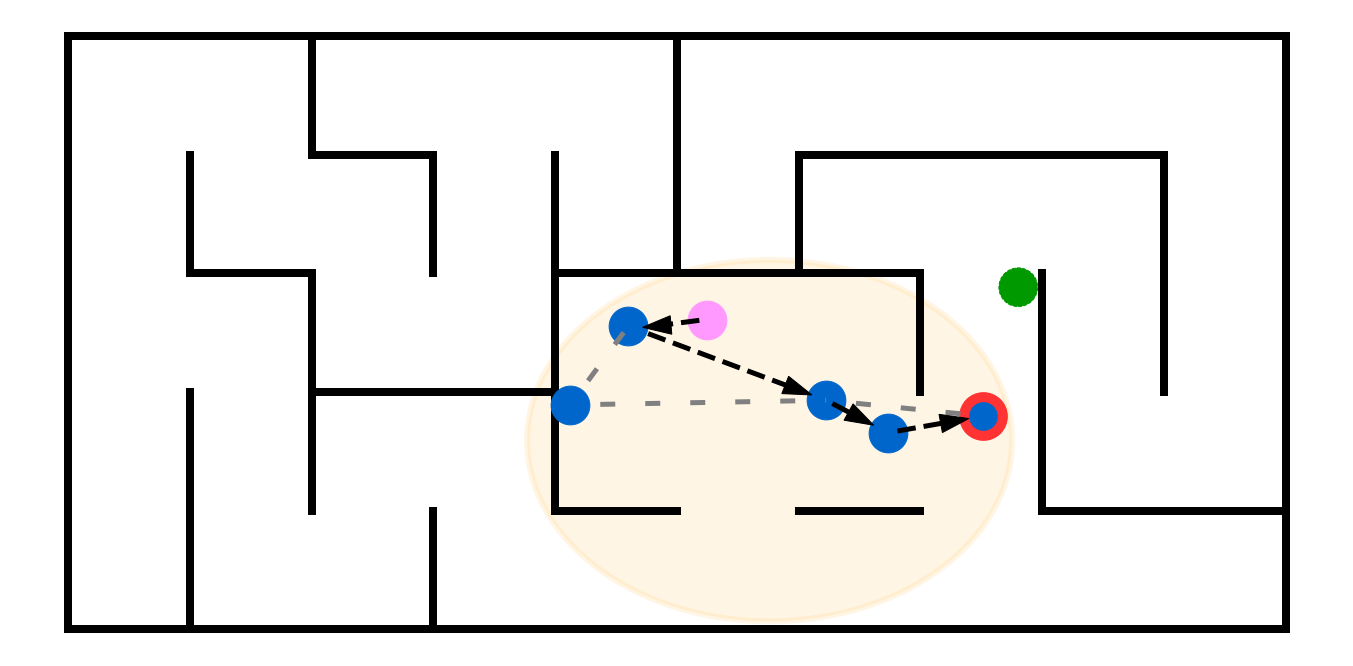

In [692]:
fig = plt.figure(figsize=(24, 12))
plt.tick_params(labelsize=14)

plot_topdown(env, plt, linewidth=8)
ax = plt.gca()
ax.axis('off')

to_plot_exploration_edges = exploration_edges[[0, 1, 4]]

starts = positions[to_plot_exploration_edges[:, 0], :2]
ends = positions[to_plot_exploration_edges[:, 1], :2]
lc = mc.LineCollection(list(zip(starts, ends)),
                       linewidths=5, color='gray', linestyle=(3, (3, 6)), zorder=10)
ax.add_collection(lc)

full_path = [good_start[:2], *positions[exploration_path, :2]] # , good_goal[:2]]
full_path = list(map(tuple, full_path))
lines = list(zip(full_path, full_path[1:]))

new_lines = []

for line in lines:
    x, y = line[1]
    dx = (x - line[0][0]) / 10
    dy = (y - line[0][1]) / 10
    change_x = 15
    x = x - change_x * np.sign(dx)
    y = y - change_x * (dy / dx)
    plt.arrow(x - dx, y - dy, dx, dy, head_width=20, length_includes_head=True, color='black', zorder=20)
    
    new_lines.append(((line[0][0] + dx, line[0][1] + dy), (x - dx, y - dy)))

# lc2 = mc.LineCollection(lines,
#                        linewidths=20, color='gold', alpha=0.5, zorder=15)
# ax.add_collection(lc2)
lc1 = mc.LineCollection(new_lines,
                       linewidths=5, color='black', linestyle='--', zorder=20)
ax.add_collection(lc1)
    
frontier_landmarks = [79]
    
exploration_landmarks = np.setdiff1d(np.unique(exploration_edges), frontier_landmarks).tolist()

plt.scatter(positions[exploration_landmarks, 0], positions[exploration_landmarks, 1], s=DOT_SIZE,
            color=LANDMARK_COLOR, label='Landmarks', zorder=9)
plt.scatter(positions[frontier_landmarks, 0], positions[frontier_landmarks, 1], s=DOT_SIZE, linewidths=10,
            color=LANDMARK_COLOR, edgecolor=FRONTIER_COLOR, label='Frontier landmarks', zorder=9)
plt.scatter(*good_start[:2], marker='o', s=DOT_SIZE, color=START_COLOR, label='Start', zorder=9)
plt.scatter(*positions[good_path[4], :2], marker='o', s=DOT_SIZE, color=NEW_LANDMARK_COLOR,
            label='New Landmark', linestyle='--', zorder=9)
explored = []
explored.append(matplotlib.patches.Ellipse((225, -180), 510, 390))
pc = mc.PatchCollection(explored, facecolor='orange', alpha=0.1, edgecolor='orange', linewidth=6, zorder=0)
ax.add_collection(pc)
plt.savefig('/mnt/brain1/scratch/choang/icml/figures/successor-landmarks-intro-figure-exploration.png')

In [693]:
def plot_invis(env, fig):
    env.reset()
    state = env.state

    for s in state.sectors:
        # Plot sector on map
        for l in s.lines:
            if l.is_blocking:
                fig.plot([l.x1, l.x2], [l.y1, l.y2], color='black', alpha=0)

In [694]:
exploration_path

[36, 74, 77, 79]

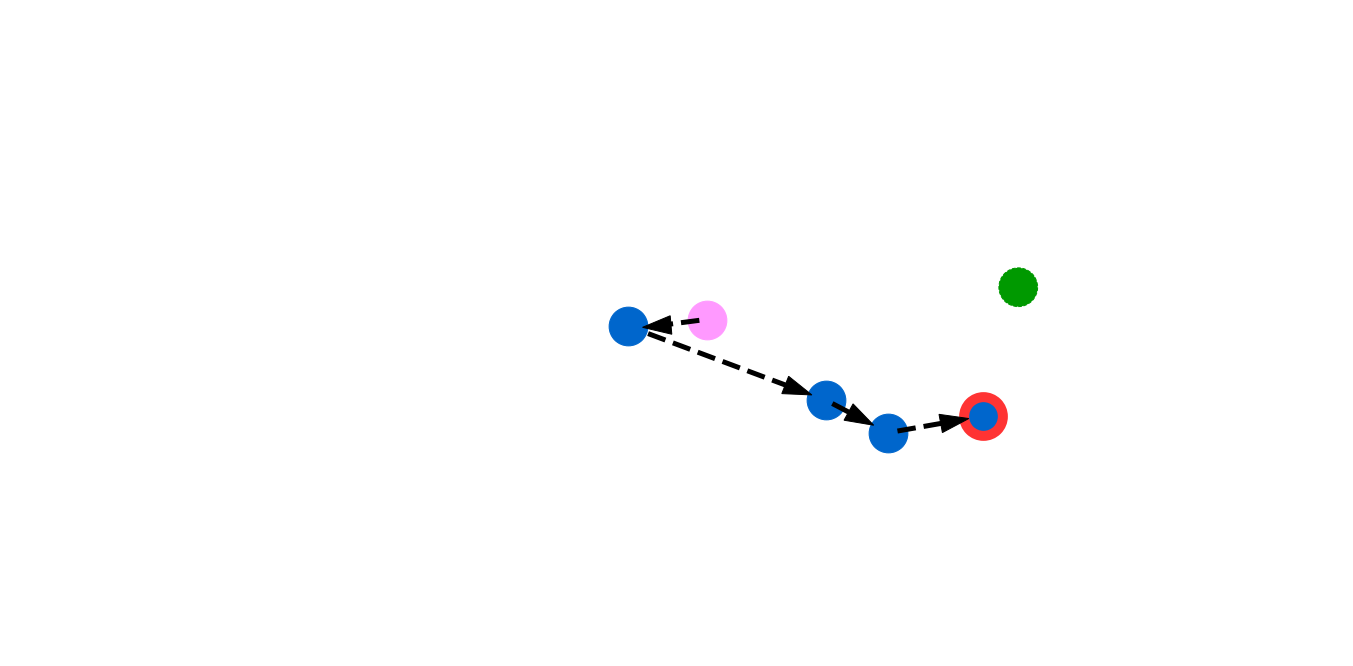

In [696]:
fig = plt.figure(figsize=(24, 12))
plt.tick_params(labelsize=14)
ax = plt.gca()
ax.axis('off')
plot_invis(env, ax)

full_path = [good_start[:2], *positions[exploration_path, :2]] # , good_goal[:2]]
full_path = list(map(tuple, full_path))
lines = list(zip(full_path, full_path[1:]))

new_lines = []

for line in lines:
    x, y = line[1]
    dx = (x - line[0][0]) / 10
    dy = (y - line[0][1]) / 10
    change_x = 15
    x = x - change_x * np.sign(dx)
    y = y - change_x * (dy / dx)
    plt.arrow(x - dx, y - dy, dx, dy, head_width=20, length_includes_head=True, color='black', zorder=20)
    
    new_lines.append(((line[0][0] + dx, line[0][1] + dy), (x - dx, y - dy)))

lc1 = mc.LineCollection(new_lines,
                       linewidths=5, color='black', linestyle='--', zorder=20)
ax.add_collection(lc1)

plt.scatter(positions[exploration_path[:-1], 0], positions[exploration_path[:-1], 1], s=DOT_SIZE,
            color=LANDMARK_COLOR, label='Landmarks')
plt.scatter(positions[exploration_path[-1:], 0], positions[exploration_path[-1:], 1], s=DOT_SIZE, linewidths=10,
            color=LANDMARK_COLOR, edgecolor=FRONTIER_COLOR, label='Frontier landmarks')
plt.scatter(*good_start[:2], marker='o', s=DOT_SIZE, color=START_COLOR, label='Start')
plt.scatter(*positions[good_path[4], :2], marker='o', s=DOT_SIZE, color=NEW_LANDMARK_COLOR,
            label='New Landmark', linestyle='--')
plt.savefig('/mnt/brain1/scratch/choang/icml/figures/successor-landmarks-intro-figure-transitions.png')

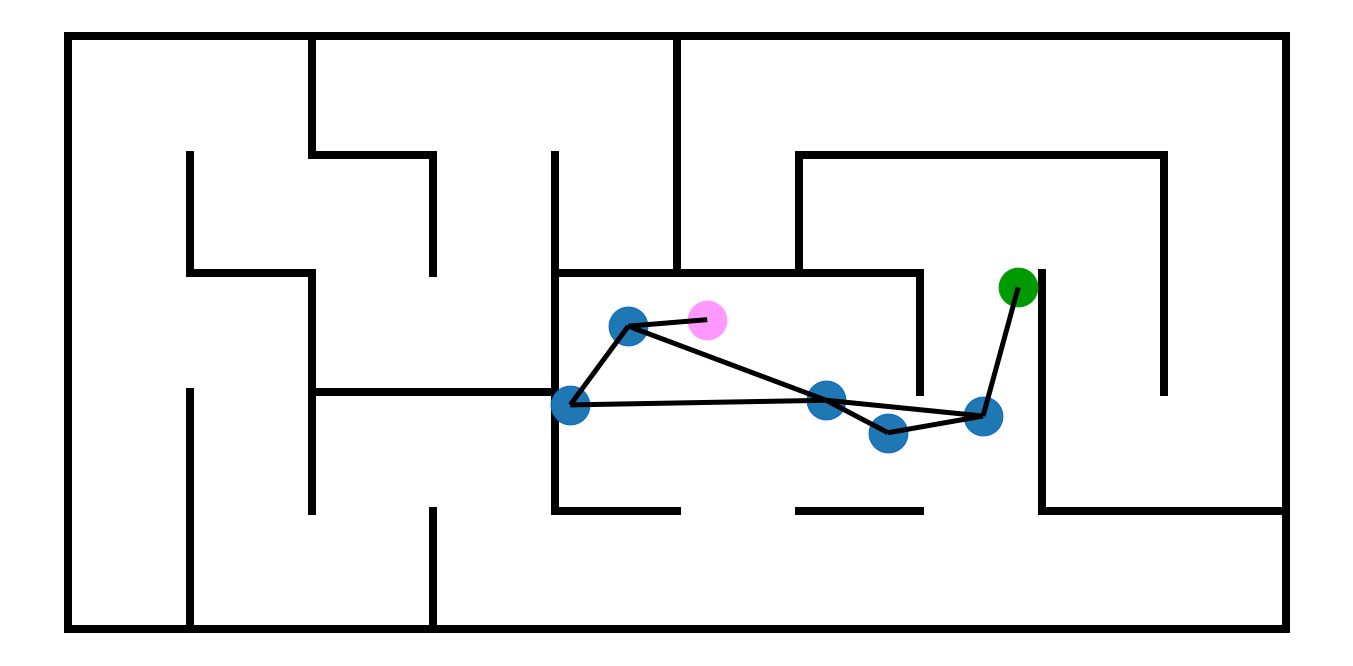

In [697]:
fig = plt.figure(figsize=(24, 12))
plt.tick_params(labelsize=14)

plot_topdown(env, plt, linewidth=8)

ax = plt.gca()
ax.axis('off')

starts = np.vstack([good_start[:2], positions[exploration_edges[:, 0], :2],
                    positions[exploration_path[-1], :2]])
ends = np.vstack([positions[exploration_path[0], :2], positions[exploration_edges[:, 1], :2],
                  positions[good_path[4], :2]])
lc = mc.LineCollection(list(zip(starts, ends)),
                       linewidths=5, color='black', zorder=10)
ax.add_collection(lc)

exploration_landmarks = np.unique(exploration_edges).tolist()

plt.scatter(positions[exploration_landmarks, 0], positions[exploration_landmarks, 1], s=DOT_SIZE,
            edgecolor=LANDMARK_COLOR, label='Landmarks', zorder=9)
plt.scatter(*good_start[:2], marker='o', s=DOT_SIZE, color=START_COLOR, label='Start')
plt.scatter(*positions[good_path[4], :2], marker='o', s=DOT_SIZE, color=NEW_LANDMARK_COLOR,
            label='New Landmark', zorder=9)
plt.savefig('/mnt/brain1/scratch/choang/icml/figures/successor-landmarks-intro-figure-graph.png')

In [698]:
full_landmarks = np.unique(exploration_landmarks + good_path).tolist()
cross_full_landmarks = np.array(list(it.product(full_landmarks, full_landmarks)))
full_path_edges = np.zeros((N, N), dtype=bool)
full_path_edges[cross_full_landmarks[:, 0], cross_full_landmarks[:, 1]] = 1
full_path_edges = edge_weights.copy() * full_path_edges
full_path_edges = np.argwhere(full_path_edges > 0)

In [699]:
full_path_edges.sort(axis=1)
full_path_edges = np.unique(full_path_edges, axis=0)

In [700]:
good_path_edges = np.array(list(zip(good_path, good_path[1:])))
good_path_edges.sort(axis=1)

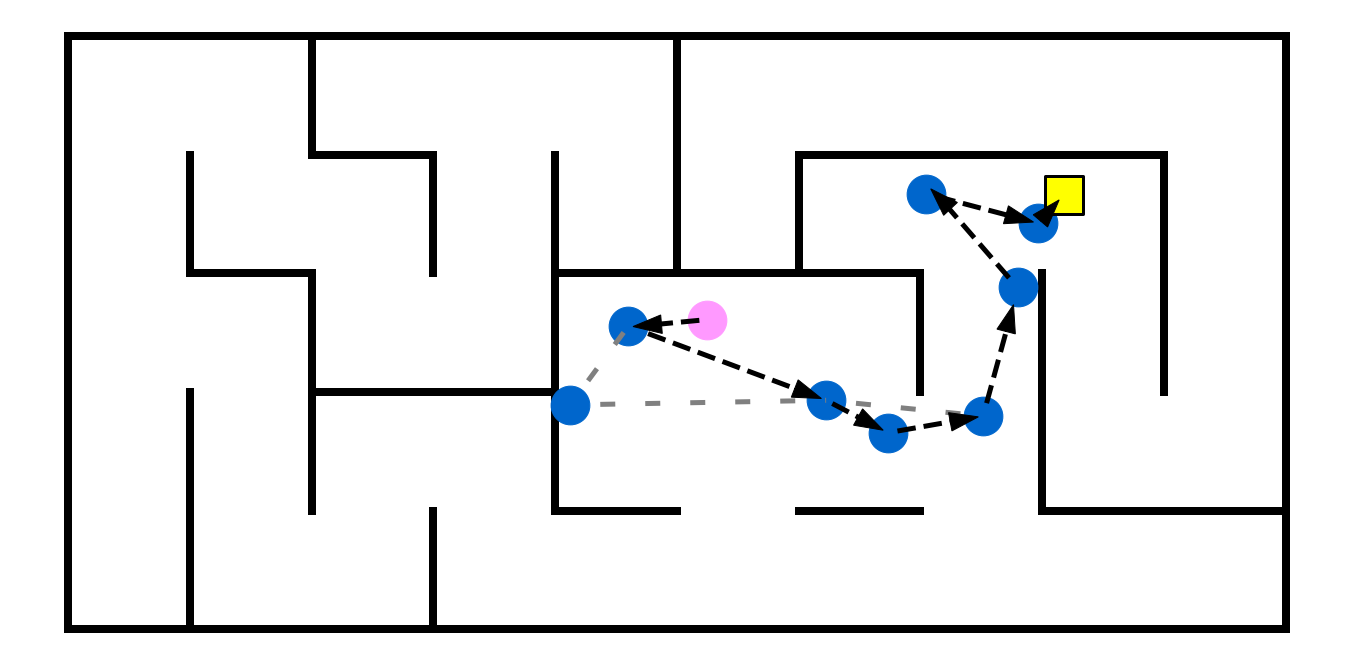

In [703]:
fig = plt.figure(figsize=(24, 12))
plt.tick_params(labelsize=14)

plot_topdown(env, plt, linewidth=8)

ax = plt.gca()
ax.axis('off')

to_plot_full_path_edges = full_path_edges[[0, 1, 4]]

starts = positions[to_plot_full_path_edges[:, 0], :2]
ends = positions[to_plot_full_path_edges[:, 1], :2]
lc = mc.LineCollection(list(zip(starts, ends)),
                       linewidths=5, color='gray', linestyle=(3, (3, 6)), zorder=15)
ax.add_collection(lc)

full_path = [good_start[:2], *positions[good_path, :2], good_goal[:2]]
full_path = list(map(tuple, full_path))
lines = list(zip(full_path, full_path[1:]))

new_lines = []

for line in lines:
    x, y = line[1]
    dx = (x - line[0][0]) / 10
    dy = (y - line[0][1]) / 10
    change_x = 5
    x = x - change_x * np.sign(dx)
    y = y - change_x * (dy / dx)
    plt.arrow(x - dx, y - dy, dx, dy, head_width=20, length_includes_head=True, color='black', zorder=20)
    
    new_lines.append(((line[0][0] + dx, line[0][1] + dy), (x - dx, y - dy)))

lc1 = mc.LineCollection(new_lines,
                       linewidths=5, color='black', linestyle='--', zorder=20)
ax.add_collection(lc1)

# lc2 = mc.LineCollection(lines,
#                        linewidths=20, color='gold', alpha=0.5, zorder=16)
# ax.add_collection(lc2)
    
full_landmarks = np.unique(full_path_edges).tolist()

plt.scatter(positions[full_landmarks, 0], positions[full_landmarks, 1], s=DOT_SIZE,
            color=LANDMARK_COLOR, label='Landmarks', zorder=8)
plt.scatter(*good_start[:2], marker='o', s=DOT_SIZE, color=START_COLOR, label='Start')
plt.scatter(*good_goal[:2], marker='s', s=DOT_SIZE, color='yellow', linewidths=3,
            edgecolor='black', label='Goal', zorder=9)
plt.savefig('/mnt/brain1/scratch/choang/icml/figures/successor-landmarks-intro-figure-evaluation.png')

In [501]:
graph = nx.from_numpy_array(edge_weights, create_using=nx.DiGraph)

In [839]:
path_info = []
 
for start, goal in [([-50, -300, 270], [-450, 0, 0]), ([460, 50, 90], [292,  184,  156])]:
    pair = [start, goal]
    path_info.append(get_path(pair, feature_model, dsr_model, graph))

SF start: 22
SF goal: 136
Found path: [22, 57, 23, 33, 31, 61, 91, 111, 110, 107, 108, 145, 121, 114, 123, 136]
SF start: 174
SF goal: 238
Found path: [174, 177, 163, 184, 187, 186, 182, 180, 179, 178, 176, 221, 199, 198, 228, 197, 196, 232, 246, 234, 238]


(0.0, 1.0, 0.0, 1.0)

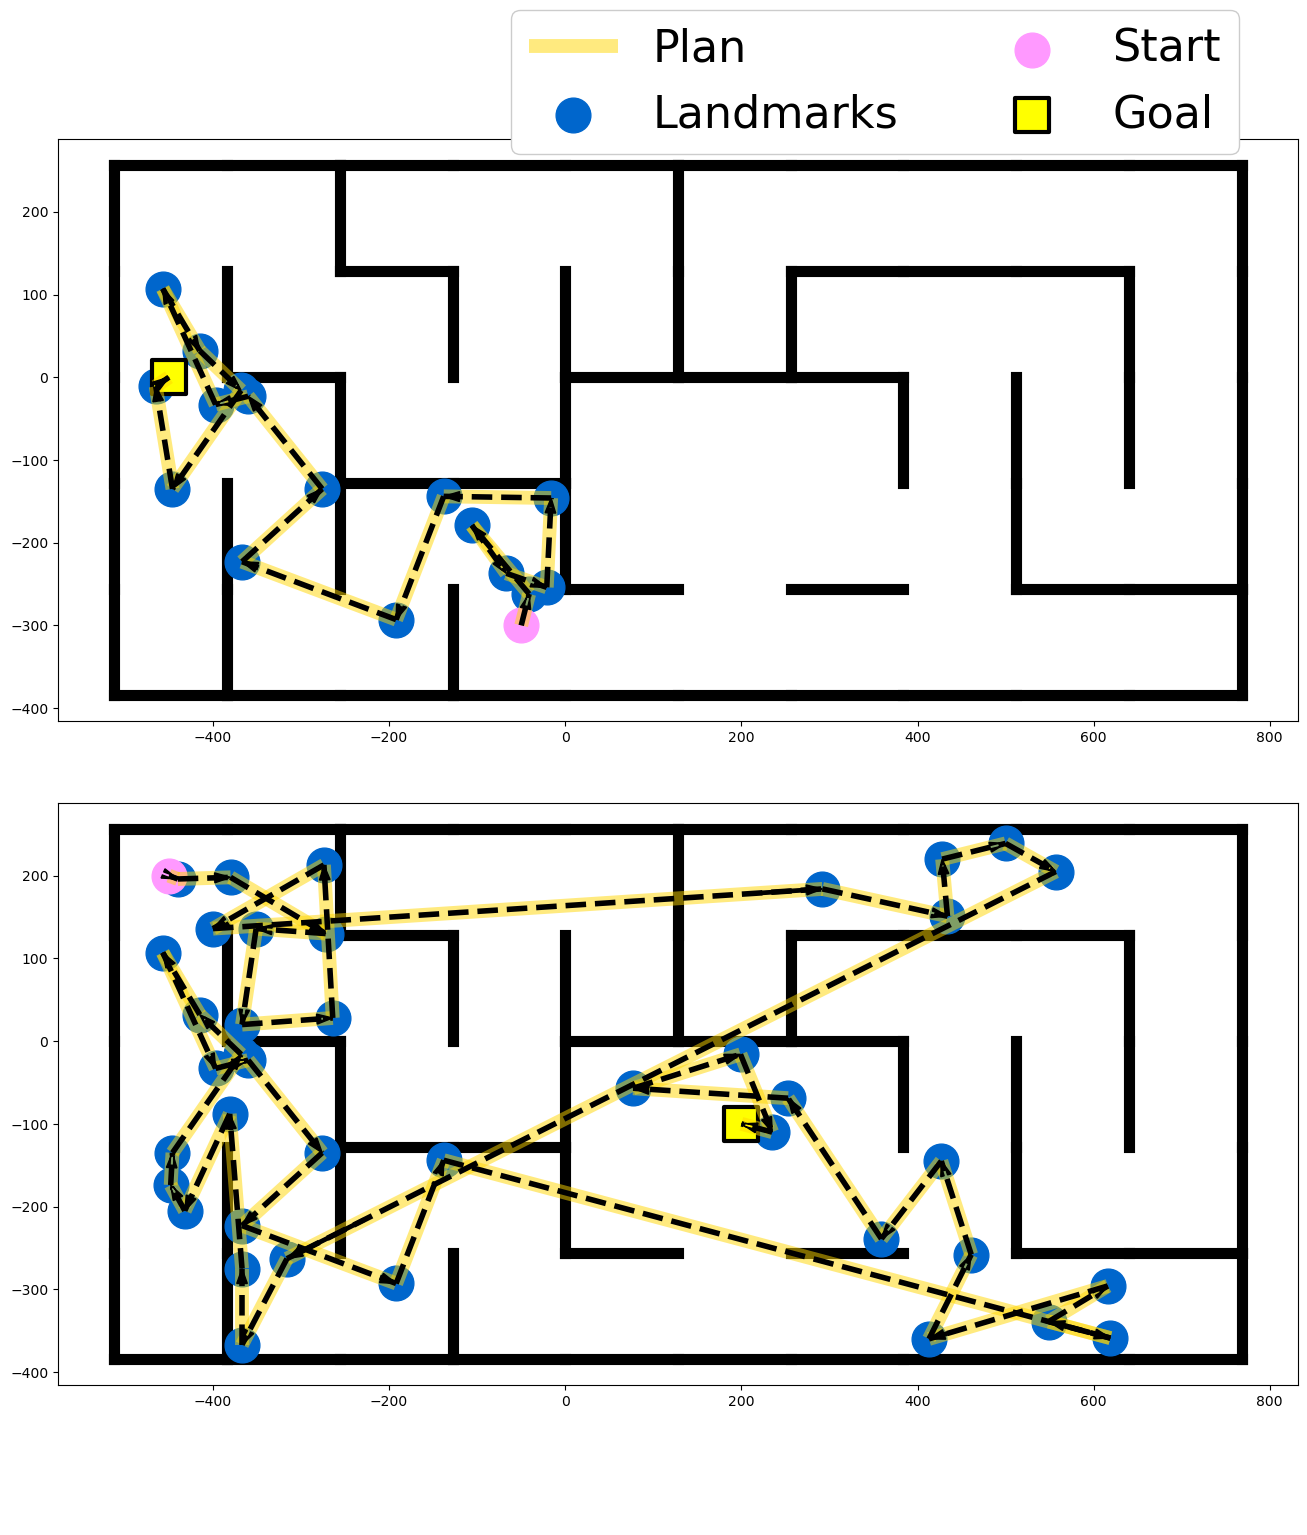

In [1097]:
gridspec = {'height_ratios': [1, 1, 0.1]}
fig, axes = plt.subplots(3, 1, figsize=(16, 18), gridspec_kw = gridspec)
plt.subplots_adjust(hspace=0.2)

for path, ax in zip(path_info, axes[:2]):
    good_start, good_goal, good_path = path
    plot_topdown(env, ax, linewidth=8)
    ax.axis('on')

    full_path = [good_start[:2], *positions[good_path, :2], good_goal[:2]]
    full_path = list(map(tuple, full_path))
    lines = list(zip(full_path, full_path[1:]))

    for i, line in enumerate(lines):
        x, y = line[1]
        dx = (x - line[0][0]) / 10
        dy = (y - line[0][1]) / 10
        ax.arrow(x - dx, y - dy, dx, dy, width=4, length_includes_head=True, color='black', zorder=20)

    lc2 = mc.LineCollection(lines,
                           linewidths=10, color='gold', alpha=0.5, zorder=16, label='Plan')
    ax.add_collection(lc2)
    lc1 = mc.LineCollection(lines,
                           linewidths=4, color='black', linestyle='--', zorder=20)
    ax.add_collection(lc1)

    ax.scatter(positions[good_path, 0], positions[good_path, 1], s=625,
                color=LANDMARK_COLOR, label='Landmarks', zorder=9)
    ax.scatter(*good_start[:2], marker='o', s=625, color=START_COLOR, label='Start', zorder=10)
    ax.scatter(*good_goal[:2], marker='s', s=625, color='yellow', linewidths=3, edgecolor='black', label='Goal', zorder=11)
    scatter = ax.scatter(positions[good_path, 0], positions[good_path, 1], s=625,
                color=LANDMARK_COLOR, zorder=9, alpha=0)
axes[0].legend(loc='upper right', fontsize=32, ncol=2, bbox_to_anchor=(0.97, 1.26), facecolor='white', framealpha=1)

axes[2].axis('off')
# cbar = plt.colorbar(scatter, cax=axes[2], orientation='horizontal', pad=0.20, alpha=0)
# cbar.ax.tick_params(labelsize=0) 
# cbar.set_label('Relative Rank of Landmark Visitations', fontsize=40)
# cbar.ax.set_visible(False)

# plt.savefig('/mnt/brain1/scratch/choang/icml/figures/good-fixed-spawn-paths.png')

# SFS ViZDoom Heatmaps

1. sample points uniformly across map
2. for each point, move around until buffer is full
3. then compute SFS relative to start position

In [871]:
def get_features(state, feature_model, dsr_model, norm=True, numpy=True):
    features = feature_model(torch.Tensor(state).unsqueeze(0).to(device))
    s_features = dsr_model(features, mode='dsr')
    if norm:
        features = features / torch.norm(features, p=2, dim=1, keepdim=True)
        s_features = torch.mean(s_features, dim=1)
        s_features = s_features / torch.norm(s_features, p=2, dim=1, keepdim=True)
    if numpy:
        features = features.detach().cpu().numpy().squeeze()
        s_features = s_features.detach().cpu().numpy().squeeze()
    return features, s_features

In [870]:
def get_full_state(env, position, repeat=False):
    if repeat:
        return env.get_obs_at(position, idx=-1)
    env.get_obs_at(position)
    for _ in range(3):
        state, _, _, info = env.step(env.action_space.sample())
    return (state, info.position)

In [872]:
eval_dir = '../data/fixed-spawn-small/run_9_no_temporal/'
# eval_dir = '../data/visualize/run_8'

In [873]:
config = json.load(open(os.path.join(eval_dir, 'params.json')))
config['env']['config'] = '../' + config['env']['config']
config['agent']['feature_model_kwargs']['fixed_weights_path'] = '../' + \
    config['agent']['feature_model_kwargs']['fixed_weights_path'] 

In [874]:
with open('../experiments/configs/2589-small-fixed-start-goal-pairs.json') as f:
    goal_pairs = json.load(f)

In [875]:
env = VizDoomEnv(**config['env'])

In [876]:
itr = 200000 - 1

In [877]:
feature_model = FixedVizDoomModel(**config['agent']['feature_model_kwargs'])
feature_model.to(device)
weights = torch.load(os.path.join(eval_dir, 'itr_{}.pkl'.format(itr)), map_location=device)
dsr_model = DsrModel(env.observation_space.shape,
                     env.action_space.n, **config['agent']['model_kwargs']).to(device)
dsr_model.load_state_dict(weights['agent_state_dict']['model'])
dsr_model.eval()
dsr_model.to(device)

DsrModel(
  (dsr): MlpModel(
    (model): Sequential(
      (0): Linear(in_features=2048, out_features=2048, bias=True)
      (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=2048, out_features=1024, bias=True)
      (4): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Linear(in_features=1024, out_features=14336, bias=True)
    )
  )
  (q_estimate): Linear(in_features=2048, out_features=1, bias=True)
)

In [60]:
start_pos = np.array([-450, 200, 0])

In [70]:
start_pos = np.array([180, 66, 6])

In [103]:
start_pos = np.array([750, -350, 180])

In [94]:
env.reset()
start_state, start_pos = get_full_state(env, start_pos, True)
start_f, start_sf = get_features(start_state, feature_model, dsr_model)

In [95]:
size_per_box = 10
num_samples_per_box = 1

In [96]:
x_starts = range(int(env.min_x), int(env.max_x), size_per_box)
y_starts = range(int(env.min_y), int(env.max_y), size_per_box)

In [97]:
print(len(list(it.product(x_starts, y_starts))))

8192


In [98]:
fs_data = defaultdict(list)
sfs_data = defaultdict(list)
i = 0
for x_start, y_start in it.product(x_starts, y_starts):
    for _ in range(num_samples_per_box):
        sample_x = np.random.uniform(x_start, x_start + size_per_box)
        sample_y = np.random.uniform(y_start, y_start + size_per_box)
        sample_theta = np.random.uniform(0, 360)
        sample_position = [sample_x, sample_y, sample_theta]
        sample_state, sample_pos = get_full_state(env, sample_position, True)
        sample_f, sample_sf = get_features(sample_state, feature_model, dsr_model)
        fs_data[(x_start, y_start)].append(np.dot(start_f, sample_f))
        sfs_data[(x_start, y_start)].append(np.dot(start_sf, sample_sf))
    i += 1
    if i > 500:
        print('RESET')
        env.reset()
        i = 0

RESET
RESET
RESET
RESET
RESET
RESET
RESET
RESET
RESET
RESET
RESET
RESET
RESET
RESET
RESET
RESET


In [104]:
start_pos = list(map(int, start_pos))

In [106]:
with open('/mnt/brain1/scratch/choang/icml/figures/data/fs_data_{}_box{}_{}_{}_{}.pkl'.format(num_samples_per_box, size_per_box, *start_pos), 'wb') as f:
    pickle.dump(fs_data, f, pickle.HIGHEST_PROTOCOL)

with open('/mnt/brain1/scratch/choang/icml/figures/data/sfs_data_{}_box{}_{}_{}_{}.pkl'.format(num_samples_per_box, size_per_box, *start_pos), 'wb') as f:
    pickle.dump(sfs_data, f, pickle.HIGHEST_PROTOCOL)

In [987]:
size_per_box = 10
num_samples_per_box = 1

In [988]:
start_pos = [128, -64, 270]

In [1001]:
with open('/mnt/brain1/scratch/choang/icml/figures/data/fs_data_{}_box{}_{}_{}_{}.pkl'.format(num_samples_per_box, size_per_box, *start_pos), 'rb') as f:
    fs_data = pickle.load(f)

with open('/mnt/brain1/scratch/choang/icml/figures/data/sfs_data_{}_box{}_{}_{}_{}.pkl'.format(num_samples_per_box, size_per_box, *start_pos), 'rb') as f:
    sfs_data = pickle.load(f)

In [1014]:
clip = np.percentile(plot_fs_data[:, 2], 99)

In [1015]:
plot_fs_data = np.array(list(fs_data.keys())).astype('float')
plot_fs_data = np.insert(plot_fs_data, 2, list(map(np.mean, list(fs_data.values()))), axis=1)
if clip is not None:
    plot_fs_data[plot_fs_data[:, 2] < clip, 2] = 0

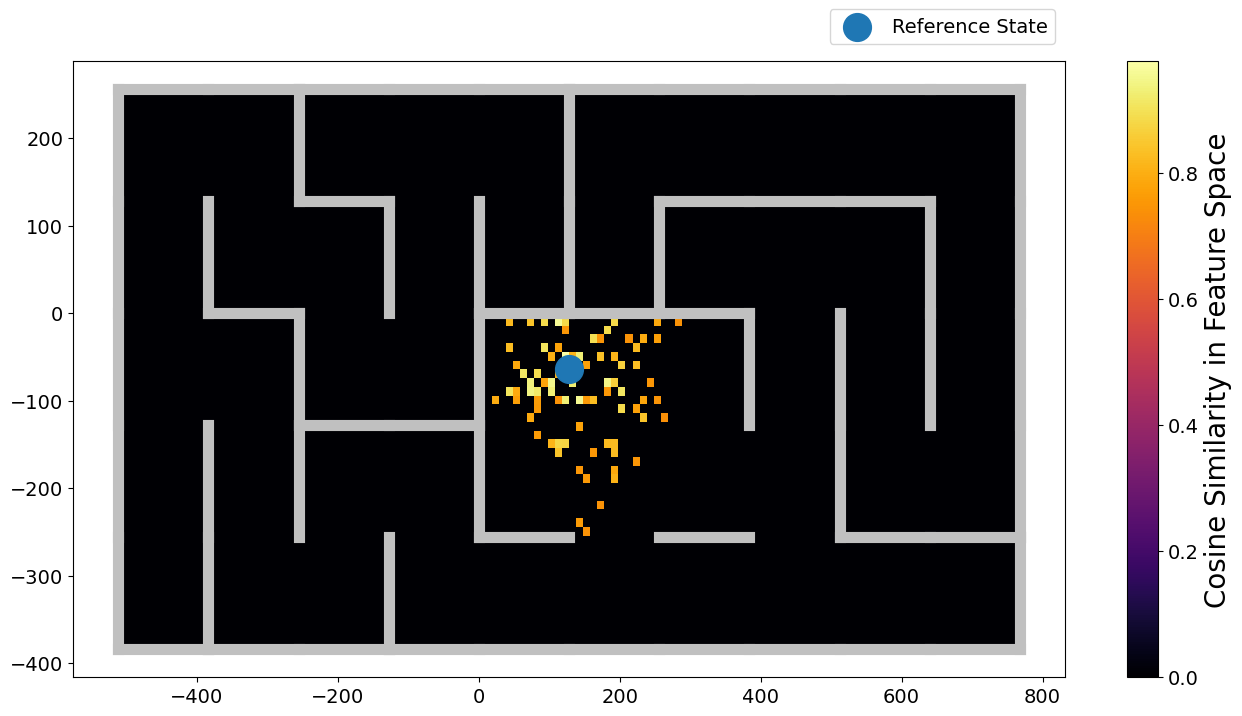

In [1016]:
plt.figure(figsize=(16, 8))
plt.tick_params(labelsize=14)
env.reset()
state = env.state

for s in state.sectors:
    # Plot sector on map
    for l in s.lines:
        if l.is_blocking:
            plt.plot([l.x1, l.x2], [l.y1, l.y2], color='silver', linewidth=8)

plt.scatter(*start_pos[:2], s=400, marker='o', zorder=10, color='tab:blue', label='Reference State')
plt.legend(loc='upper right', fontsize=14, bbox_to_anchor=(1, 1.1))

rects = []
for x, y in plot_fs_data[:, :2]:
    rect = matplotlib.patches.Rectangle((x, y), size_per_box, size_per_box)
    rects.append(rect)
rects = mc.PatchCollection(rects, cmap=cm.inferno)
rects.set_array(plot_fs_data[:, 2])
ax = plt.gca()
ax.add_collection(rects)
cbar = plt.colorbar(rects)
cbar.ax.tick_params(labelsize=14) 
cbar.set_label('Cosine Similarity in Feature Space', fontsize=20)
# if clip is not None:
#     plt.savefig('/mnt/brain1/scratch/choang/icml/figures/full_clip{}_feature_similarity_{}_samples_{}_{}_{}.png'.format(clip, num_samples_per_box, *start_pos))
# else:
#     plt.savefig('/mnt/brain1/scratch/choang/icml/figures/full_feature_similarity_{}_samples_{}_{}_{}.png'.format(num_samples_per_box, *start_pos))

In [1018]:
clip = np.percentile(plot_sfs_data[:, 2], 99)

In [1019]:
plot_sfs_data = np.array(list(sfs_data.keys())).astype('float')
plot_sfs_data = np.insert(plot_sfs_data, 2, list(map(np.mean, list(sfs_data.values()))), axis=1)
if clip is not None:
    plot_sfs_data[plot_sfs_data[:, 2] < clip, 2] = 0

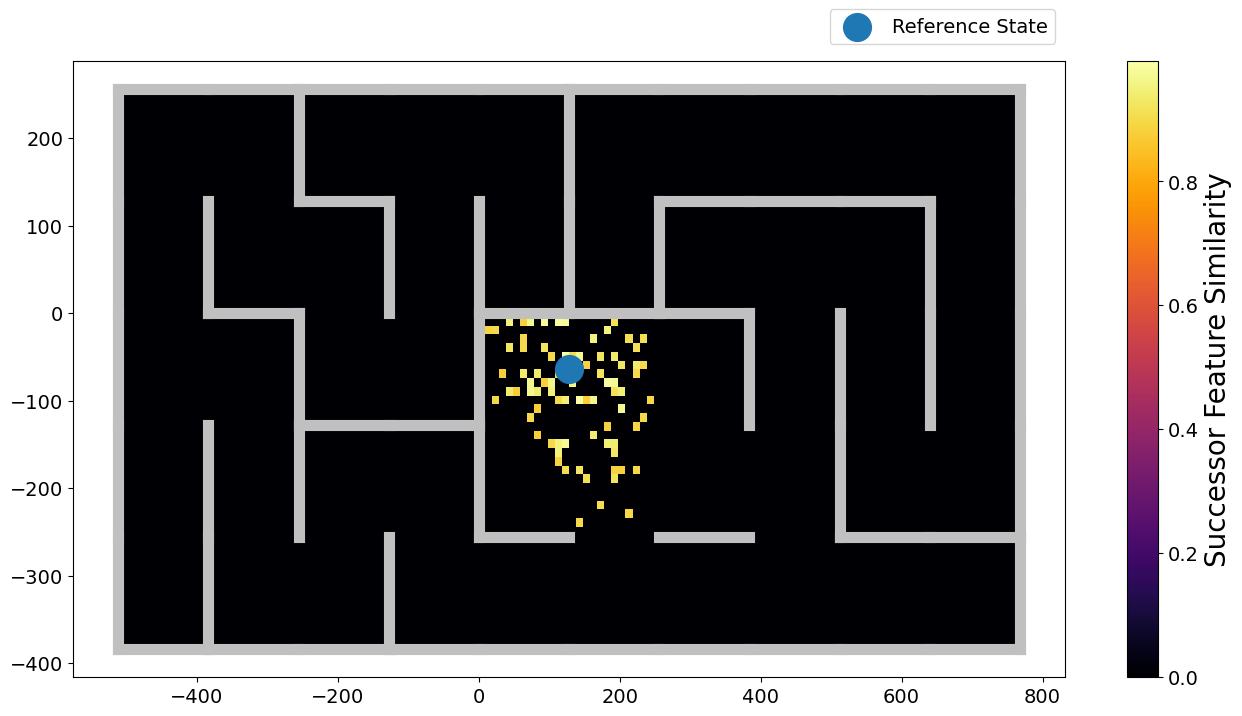

In [1020]:
plt.figure(figsize=(16, 8))
plt.tick_params(labelsize=14)
env.reset()
state = env.state

for s in state.sectors:
    # Plot sector on map
    for l in s.lines:
        if l.is_blocking:
            plt.plot([l.x1, l.x2], [l.y1, l.y2], color='silver', linewidth=8)

plt.scatter(*start_pos[:2], s=400, marker='o', zorder=10, color='tab:blue', label='Reference State')
plt.legend(loc='upper right', fontsize=14, bbox_to_anchor=(1, 1.1))

rects = []
for x, y in plot_sfs_data[:, :2]:
    rect = matplotlib.patches.Rectangle((x, y), size_per_box, size_per_box)
    rects.append(rect)
rects = mc.PatchCollection(rects, cmap=cm.inferno)
rects.set_array(plot_sfs_data[:, 2])
ax = plt.gca()
ax.add_collection(rects)
cbar = plt.colorbar(rects)
cbar.ax.tick_params(labelsize=14) 
cbar.set_label('Successor Feature Similarity', fontsize=20)
# if clip is not None:
#     plt.savefig('/mnt/brain1/scratch/choang/icml/figures/full_clip{}_sfs_{}_samples_{}_{}_{}.png'.format(clip, num_samples_per_box, *start_pos))
# else:
#     plt.savefig('/mnt/brain1/scratch/choang/icml/figures/full_sfs_{}_samples_{}_{}_{}.png'.format(num_samples_per_box, *start_pos))

In [846]:
def get_sfs_data(start_pos, size_per_box=10, num_samples_per_box=1, clip=0.9):

    with open('/mnt/brain1/scratch/choang/icml/figures/data/sfs_data_{}_box{}_{}_{}_{}.pkl'.format(num_samples_per_box, size_per_box, *start_pos), 'rb') as f:
        sfs_data = pickle.load(f)
        
    plot_sfs_data = np.array(list(sfs_data.keys())).astype('float')
    plot_sfs_data = np.insert(plot_sfs_data, 2, list(map(np.mean, list(sfs_data.values()))), axis=1)
    clipped_plot_sfs_data = plot_sfs_data.copy()
    clipped_plot_sfs_data[clipped_plot_sfs_data[:, 2] <= clip, 2] = 0
    return plot_sfs_data, clipped_plot_sfs_data

In [863]:
start_pos = [128, -64, 270]

In [864]:
start_data, clipped_start_data = get_sfs_data(start_pos)

In [865]:
end_pos = [180, 66, 6]

In [866]:
end_data, clipped_end_data = get_sfs_data(end_pos)

In [851]:
size_per_box = 10

In [852]:
used_cmap = cm.inferno
used_cmap = cm.viridis
used_cmap = cm.magma

agent_color = 'tab:cyan'

agent_size = 1150

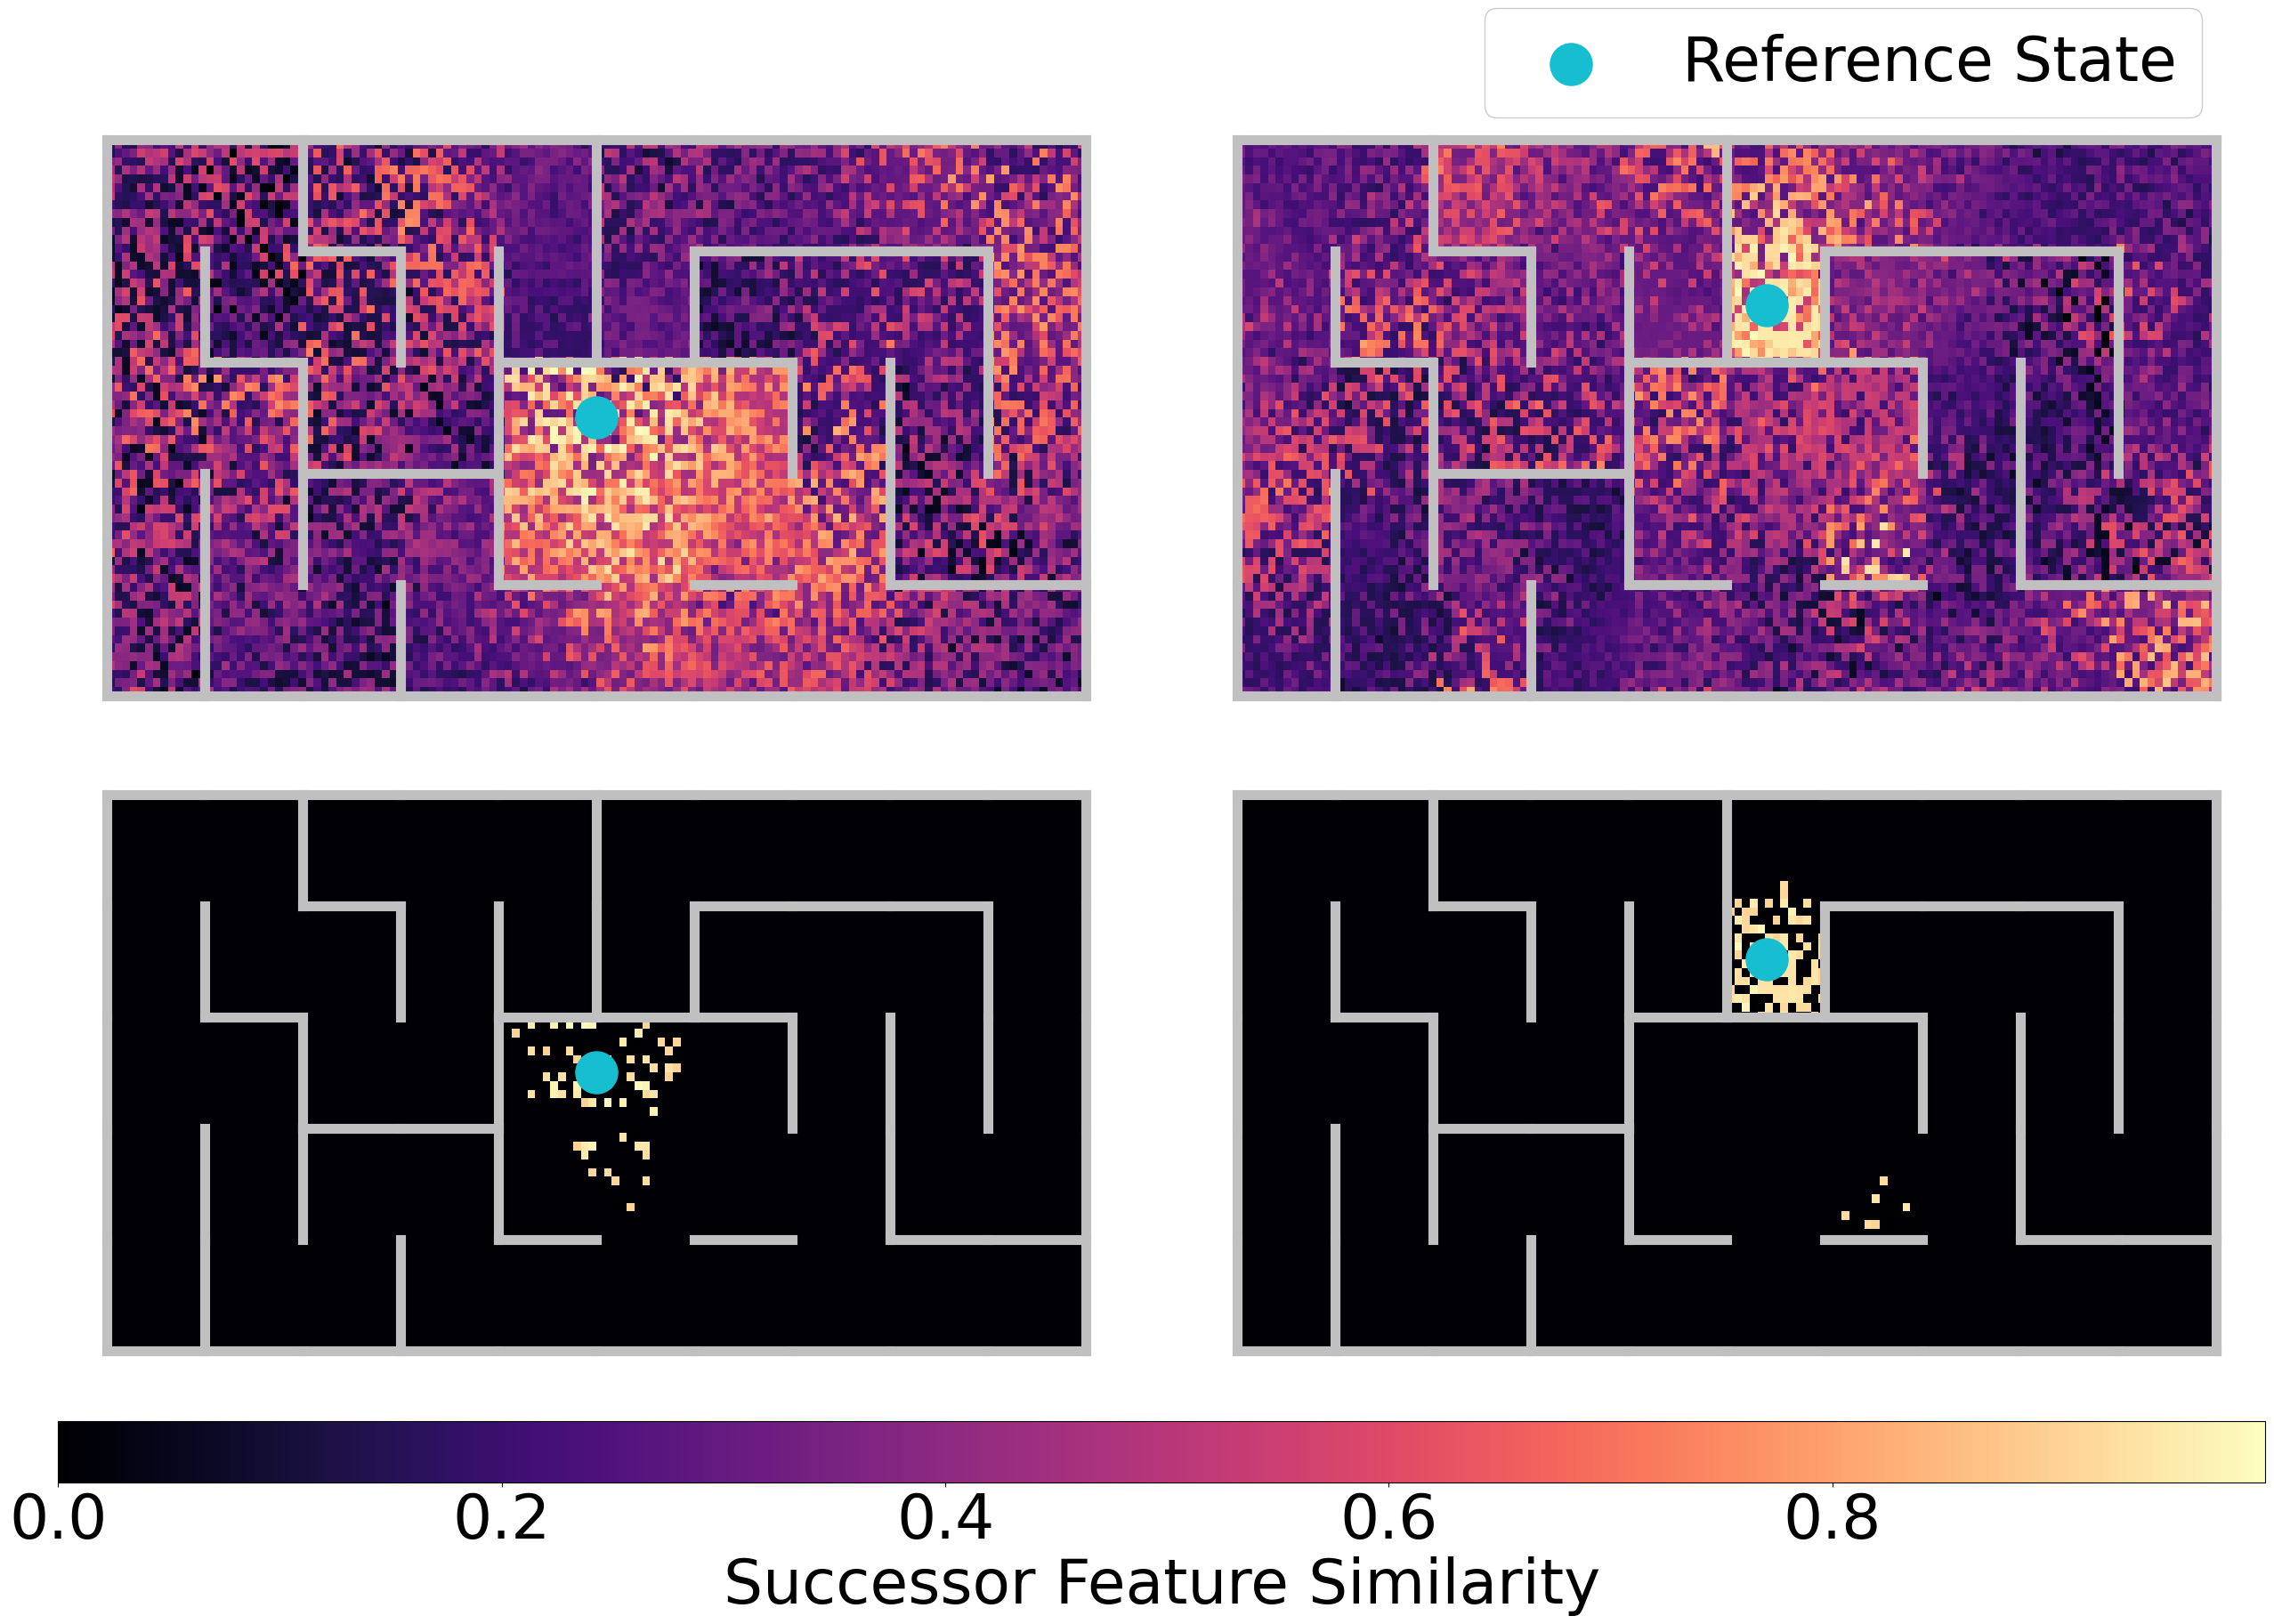

In [844]:
fig = plt.figure(figsize=(32, 20))
gridspec = {'height_ratios': [1, 1, 0.1], 'wspace': 0.05, 'hspace': 0.1}
gs = fig.add_gridspec(3, 2, **gridspec)

### TOP LEFT
ax1 = fig.add_subplot(gs[0, 0])
ax1.axis('off')
env.reset()
state = env.state

for s in state.sectors:
    # Plot sector on map
    for l in s.lines:
        if l.is_blocking:
            ax1.plot([l.x1, l.x2], [l.y1, l.y2], color='silver', linewidth=8)

ax1.scatter(*start_pos[:2], s=agent_size, marker='o', zorder=10, color=agent_color, label='Reference State')

rects = []
for x, y in start_data[:, :2]:
    rect = matplotlib.patches.Rectangle((x, y), size_per_box, size_per_box)
    rects.append(rect)
rects = mc.PatchCollection(rects, cmap=used_cmap)
rects.set_array(start_data[:, 2])
ax1.add_collection(rects)

### BOTTOM LEFT
ax2 = fig.add_subplot(gs[1, 0])
ax2.axis('off')

for s in state.sectors:
    # Plot sector on map
    for l in s.lines:
        if l.is_blocking:
            ax2.plot([l.x1, l.x2], [l.y1, l.y2], color='silver', linewidth=8)

ax2.scatter(*start_pos[:2], s=agent_size, marker='o', zorder=10, color=agent_color, label='Reference State')

rects = []
for x, y in clipped_start_data[:, :2]:
    rect = matplotlib.patches.Rectangle((x, y), size_per_box, size_per_box)
    rects.append(rect)
rects = mc.PatchCollection(rects, cmap=used_cmap)
rects.set_array(clipped_start_data[:, 2])
ax2.add_collection(rects)

### TOP RIGHT
ax3 = fig.add_subplot(gs[0, 1])
ax3.axis('off')

for s in state.sectors:
    # Plot sector on map
    for l in s.lines:
        if l.is_blocking:
            ax3.plot([l.x1, l.x2], [l.y1, l.y2], color='silver', linewidth=8)

ax3.scatter(*end_pos[:2], s=agent_size, marker='o', zorder=10, color=agent_color, label='Reference State')

rects = []
for x, y in end_data[:, :2]:
    rect = matplotlib.patches.Rectangle((x, y), size_per_box, size_per_box)
    rects.append(rect)
rects = mc.PatchCollection(rects, cmap=used_cmap)
rects.set_array(end_data[:, 2])
ax3.add_collection(rects)
ax3.legend(loc='upper right', fontsize=50, bbox_to_anchor=(0.97, 1.22), facecolor='white', framealpha=1)

### BOTTOM RIGHT
ax4 = fig.add_subplot(gs[1, 1])
ax4.axis('off')

for s in state.sectors:
    # Plot sector on map
    for l in s.lines:
        if l.is_blocking:
            ax4.plot([l.x1, l.x2], [l.y1, l.y2], color='silver', linewidth=8)

ax4.scatter(*end_pos[:2], s=agent_size, marker='o', zorder=10, color=agent_color, label='Reference State')

rects = []
for x, y in clipped_end_data[:, :2]:
    rect = matplotlib.patches.Rectangle((x, y), size_per_box, size_per_box)
    rects.append(rect)
rects = mc.PatchCollection(rects, cmap=used_cmap)
rects.set_array(clipped_end_data[:, 2])
ax4.add_collection(rects)

### COLOR BAR
ax5 = fig.add_subplot(gs[2, :])
cbar = fig.colorbar(rects, cax = ax5, orientation='horizontal', pad=0.20)
cbar.ax.tick_params(labelsize=50) 
cbar.set_label('Successor Feature Similarity', fontsize=50)
plt.savefig('/mnt/brain1/scratch/choang/icml/figures/sfs-heatmap-comparison.png', bbox_inches='tight')

In [1022]:
def show_state(state, label='', file=None):
    plt.figure()
    plt.axis('off')
    plt.imshow(np.transpose(state[:3], [1, 2, 0]))
    plt.title(label)
    if file:
        plt.savefig(file, bbox_inches='tight')

In [1262]:
ref_state, ref_pos_a = get_full_state(env, [180, 66, -20], True)
ref_f, ref_sf = get_features(ref_state, feature_model, dsr_model)

In [1263]:
test_state, test_pos_a = get_full_state(env, [290, -200, 280], True)
test_f, test_sf = get_features(test_state, feature_model, dsr_model)

In [1264]:
fs = np.dot(ref_f, test_f)
sfs = np.dot(ref_sf, test_sf)

In [1265]:
print(sfs)

0.93830407


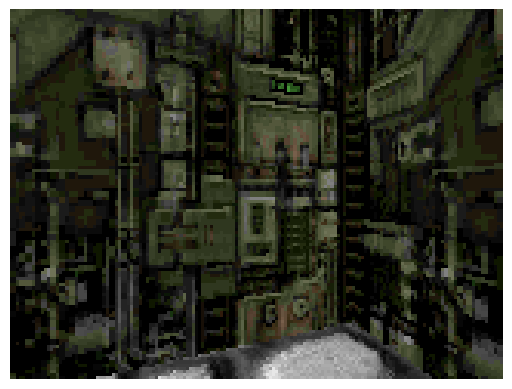

In [1266]:
show_state(ref_state, '', '/mnt/brain1/scratch/choang/icml/figures/perceptual-aliasing-a1.png')

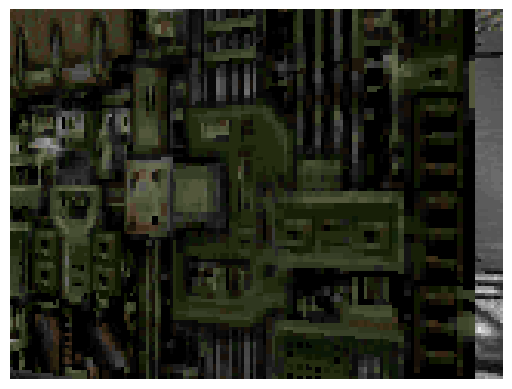

In [1267]:
show_state(test_state, '', '/mnt/brain1/scratch/choang/icml/figures/perceptual-aliasing-a2.png')

In [1268]:
ref_state, ref_pos_b = get_full_state(env, [-320, -40, 350], True)
ref_f, ref_sf = get_features(ref_state, feature_model, dsr_model)

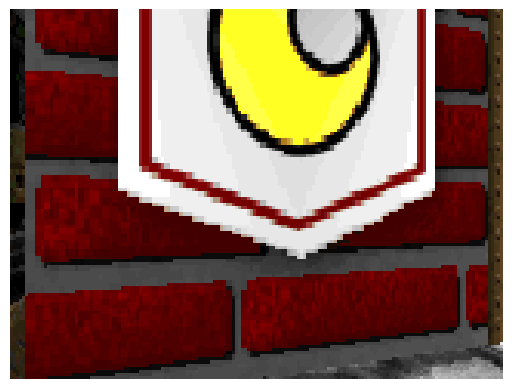

In [1269]:
show_state(ref_state, '', '/mnt/brain1/scratch/choang/icml/figures/perceptual-aliasing-b1.png')

In [1271]:
test_state, test_pos_b = get_full_state(env, [280, -310, 280], True)
test_f, test_sf = get_features(test_state, feature_model, dsr_model)

In [1272]:
fs = np.dot(ref_f, test_f)
sfs = np.dot(ref_sf, test_sf)

In [1273]:
print(sfs)

0.90710723


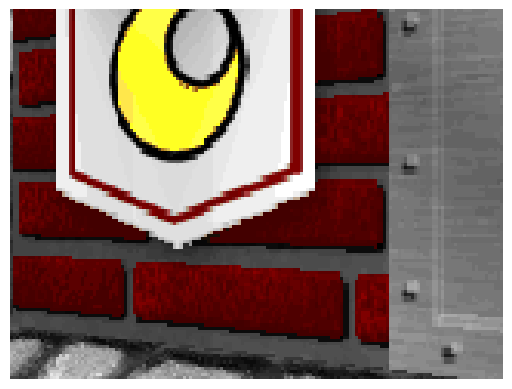

In [1274]:
show_state(test_state, '', '/mnt/brain1/scratch/choang/icml/figures/perceptual-aliasing-b2.png')

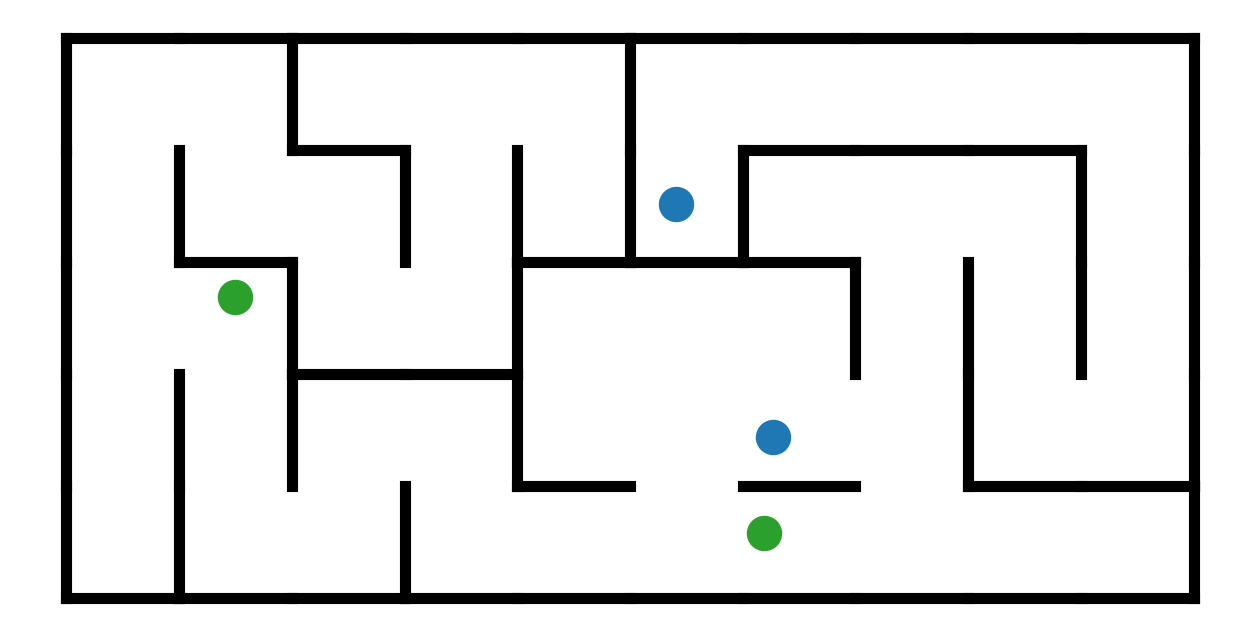

In [1283]:
plt.figure(figsize=(16, 8))
plot_topdown(env, plt, 8)
plt.axis('off')
plt.scatter(*ref_pos_a[:2], s=600, color='tab:blue')
plt.scatter(*test_pos_a[:2], s=600, color='tab:blue')
plt.scatter(*ref_pos_b[:2], s=600, color='tab:green')
plt.scatter(*test_pos_b[:2], s=600, color='tab:green')
plt.savefig('/mnt/brain1/scratch/choang/icml/figures/perceptual-aliasing-map.png', bbox_inches='tight')

## Old

In [3]:
with open('../experiments/configs/small-eval-settings.json') as f:
    small_goals = json.load(f)

In [4]:
with open('../experiments/configs/memory-small-full.json') as f:
    small_config = json.load(f)
small_config['env']['config'] = '../' + small_config['env']['config']

In [1284]:
with open('../experiments/configs/memory-train-full.json') as f:
    train_config = json.load(f)
train_config['env']['config'] = '../' + train_config['env']['config']

In [1285]:
# small_env = VizDoomEnv(**small_config['env'])
train_env = VizDoomEnv(**train_config['env'])

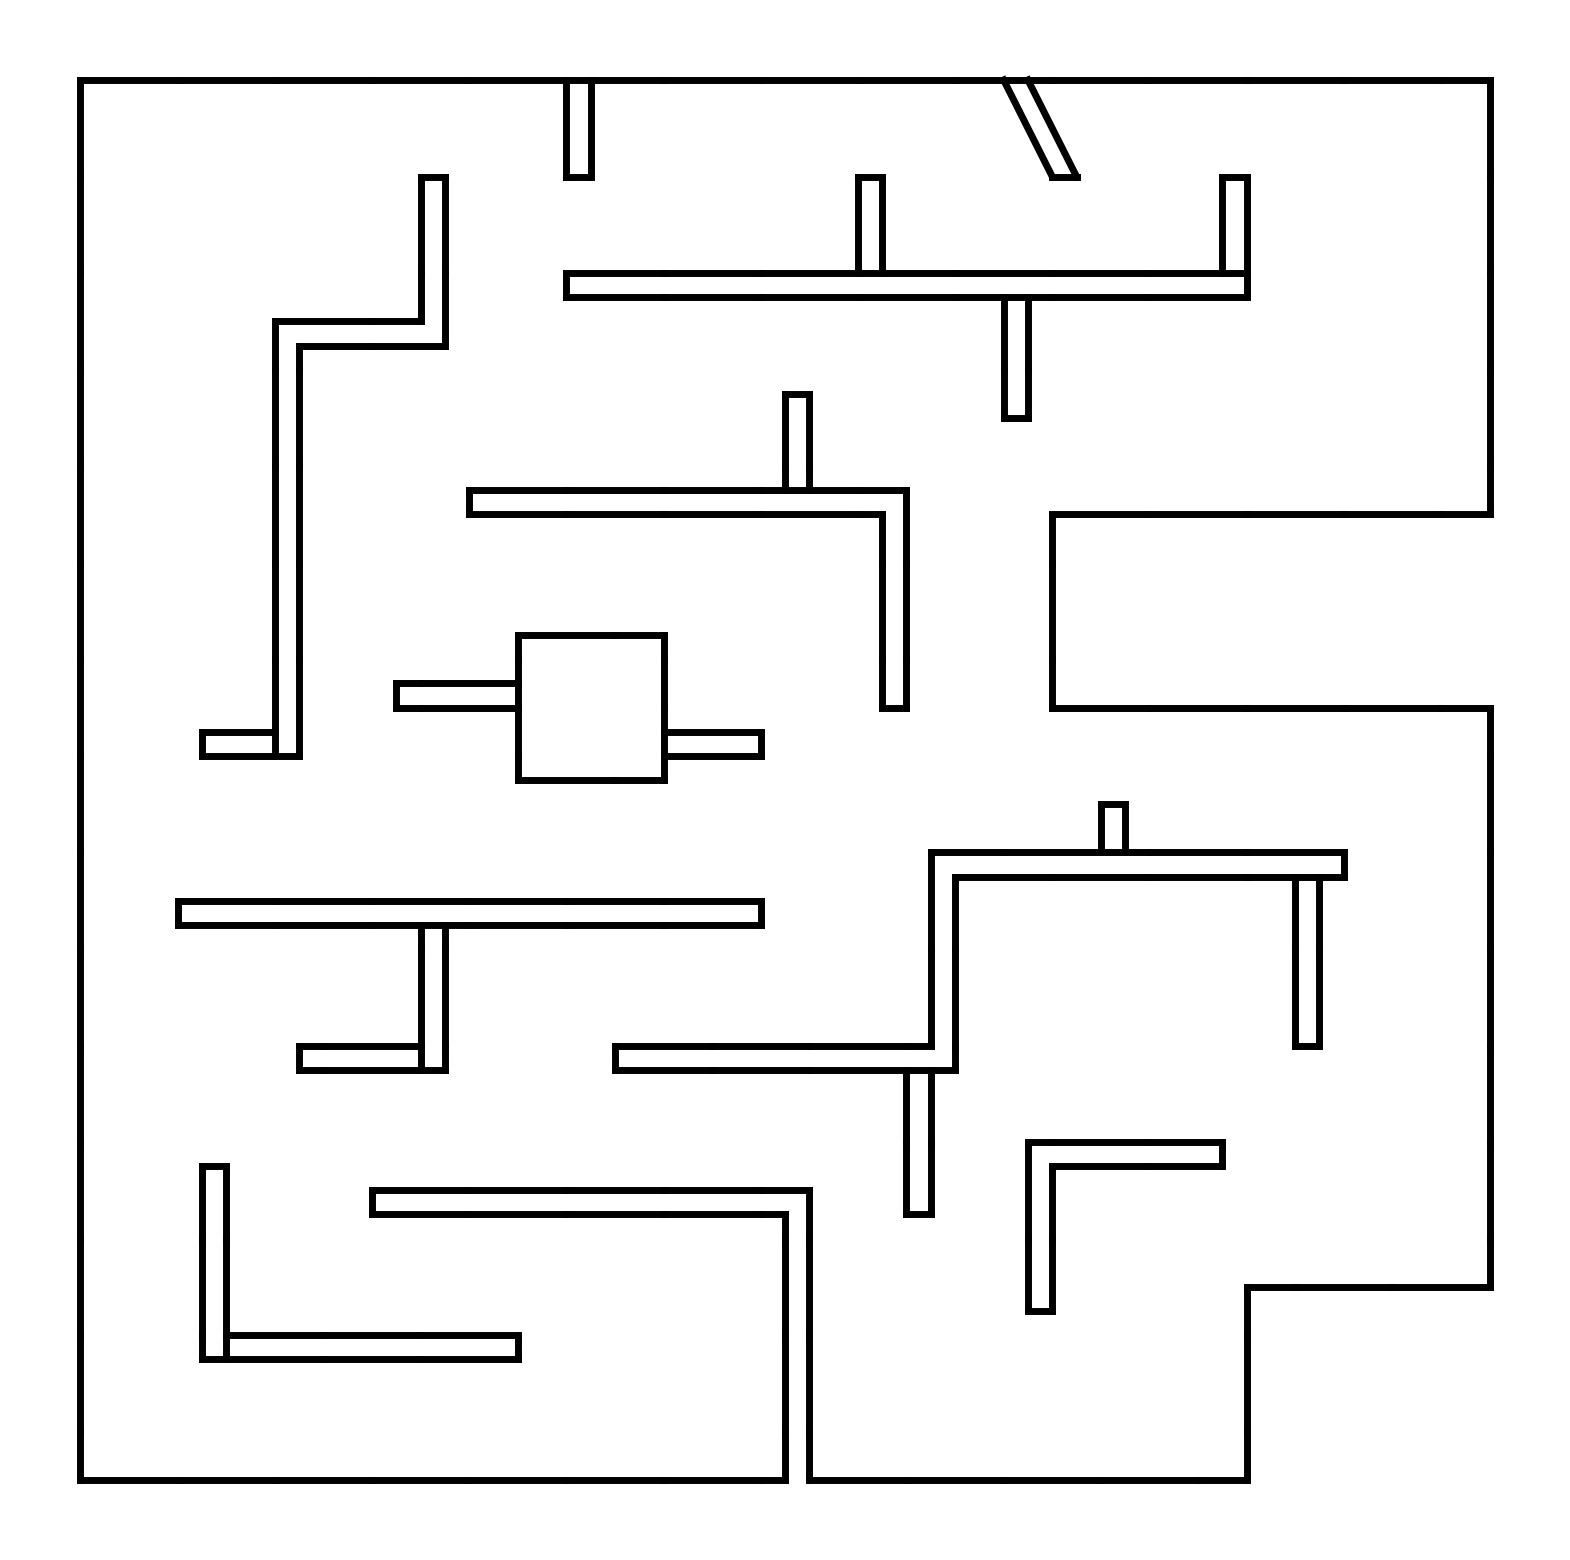

In [1289]:
plt.figure(figsize=(20, 20))
plot_topdown(train_env, plt, 5)
plt.axis('off')
plt.savefig('/mnt/brain1/scratch/choang/icml/figures/random-spawn-vizdoom.png', bbox_inches='tight')

In [7]:
levels = ['easy', 'medium', 'hard', 'hardest']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

In [735]:
colors = {
    'easy': 'tab:green',
    'medium': 'tab:blue',
    'hard': 'tab:orange',
    'hardest': 'tab:red'
}

In [718]:
with open('../experiments/configs/2589-small-fixed-start-goal-pairs.json') as f:
    small_goal_pairs = json.load(f)

In [719]:
small_goal_pairs

{'easy': [[[128, -64, 0],
   [219.6425810227652, -118.08530962222513, 173.5660594463172]],
  [[128, -64, 0], [499.29114706565315, -322.226085279648, 191.74199343395824]],
  [[128, -64, 0],
   [-1.7562313501716322, -306.86295829869476, 340.4037992785359]],
  [[128, -64, 0],
   [466.37818692326874, -37.978931381289975, 60.56278904154502]],
  [[128, -64, 0],
   [199.49409677682291, -125.04162463517456, 312.62211479648096]],
  [[128, -64, 0], [418.5219329027006, -358.54297583066045, 264.926904932809]],
  [[128, -64, 0], [10.740710234039165, -314.1352254689737, 19.8591687543748]],
  [[128, -64, 0], [461.5670734990725, -48.25094806966319, 76.26775612630213]],
  [[128, -64, 0],
   [238.80150542607404, -167.8504923227441, 342.27967759256614]],
  [[128, -64, 0], [456.286107833311, -320.76341227078404, 71.58230590022312]],
  [[128, -64, 0], [23.050833352204634, -321.8086416347587, 0.553447407490042]],
  [[128, -64, 0], [458.1157207633659, -21.12026465338368, 27.757704365337325]],
  [[128, -64, 0

In [720]:
np.array(small_goal_pairs['easy']).shape

(100, 2, 3)

In [736]:
cmap = cm.Paired

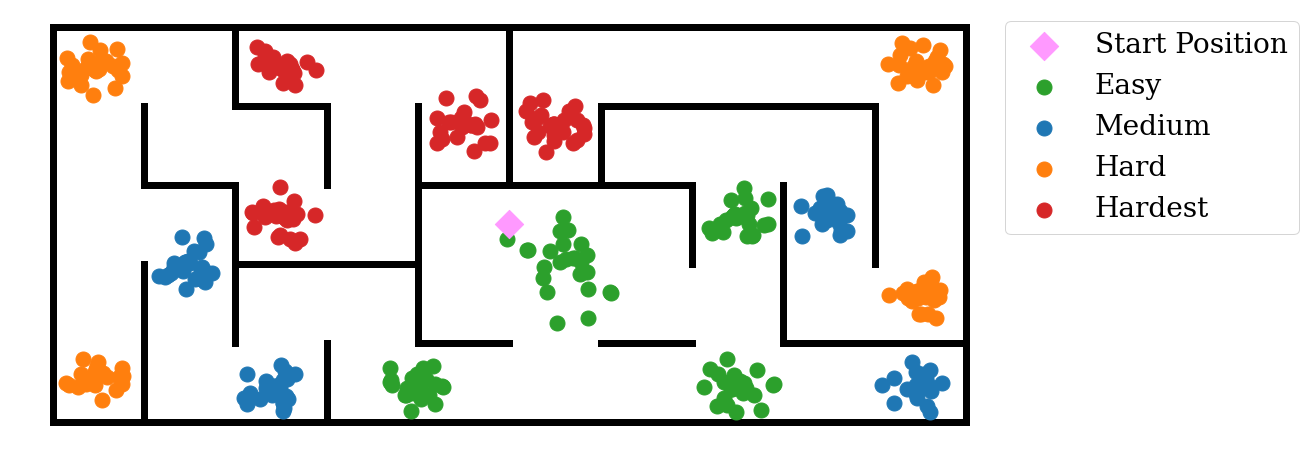

In [795]:
fig = plt.figure(figsize=(18, 8))
plt.axis('off')

ax = plt.gca()

plot_topdown(env, plt, 7)
agent = plt.scatter(*env.start_position[:2], s=400, color=START_COLOR, marker='D', label='Start Position', zorder=4)

i = 0
for level, goal_pairs in small_goal_pairs.items():
    goals = np.array(goal_pairs)[:, 1, :2]
    color = colors[level]
    plt.scatter(goals[:, 0], goals[:, 1], s=225, color=color, label=level.capitalize(), zorder=3)
    i += 1
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1), fontsize=28)
plt.savefig('/mnt/brain1/scratch/choang/icml/figures/fixed-spawn-small-maze-dotted.png', bbox_inches='tight')

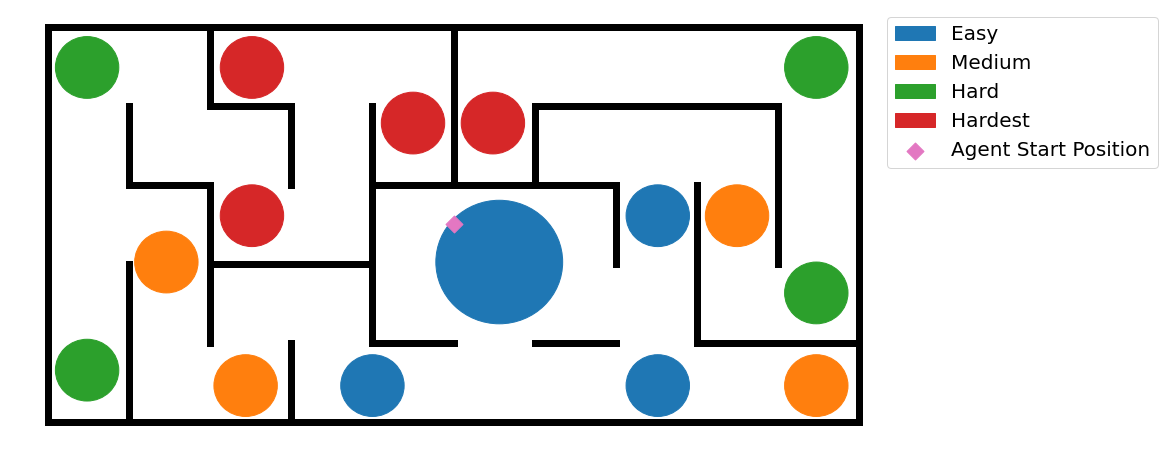

In [20]:
fig = plt.figure(figsize=(16, 8))
plt.axis('off')

ax = plt.gca()

plot_topdown(small_env, plt, 7)

circles = []
for level, color in zip(levels, colors):
    goal_areas = small_goals[level]
    for goal_area in goal_areas:
        x, y, r = goal_area
        circle = plt.Circle((x, y), r, color=color, label=level.capitalize(), zorder=-1)
        ax.add_artist(circle)
    circles.append(circle)
agent = plt.scatter(*small_config['env']['start_position'][:2], s=144, color='tab:pink', marker='D', label='Agent Start Position', zorder=1)
plt.legend(handles=[*circles, agent], loc='upper right', bbox_to_anchor=(1.3, 1), fontsize=20)
# plt.savefig('/mnt/brain1/scratch/choang/icml/figures/fixed-spawn-small-maze.png', bbox_inches='tight')

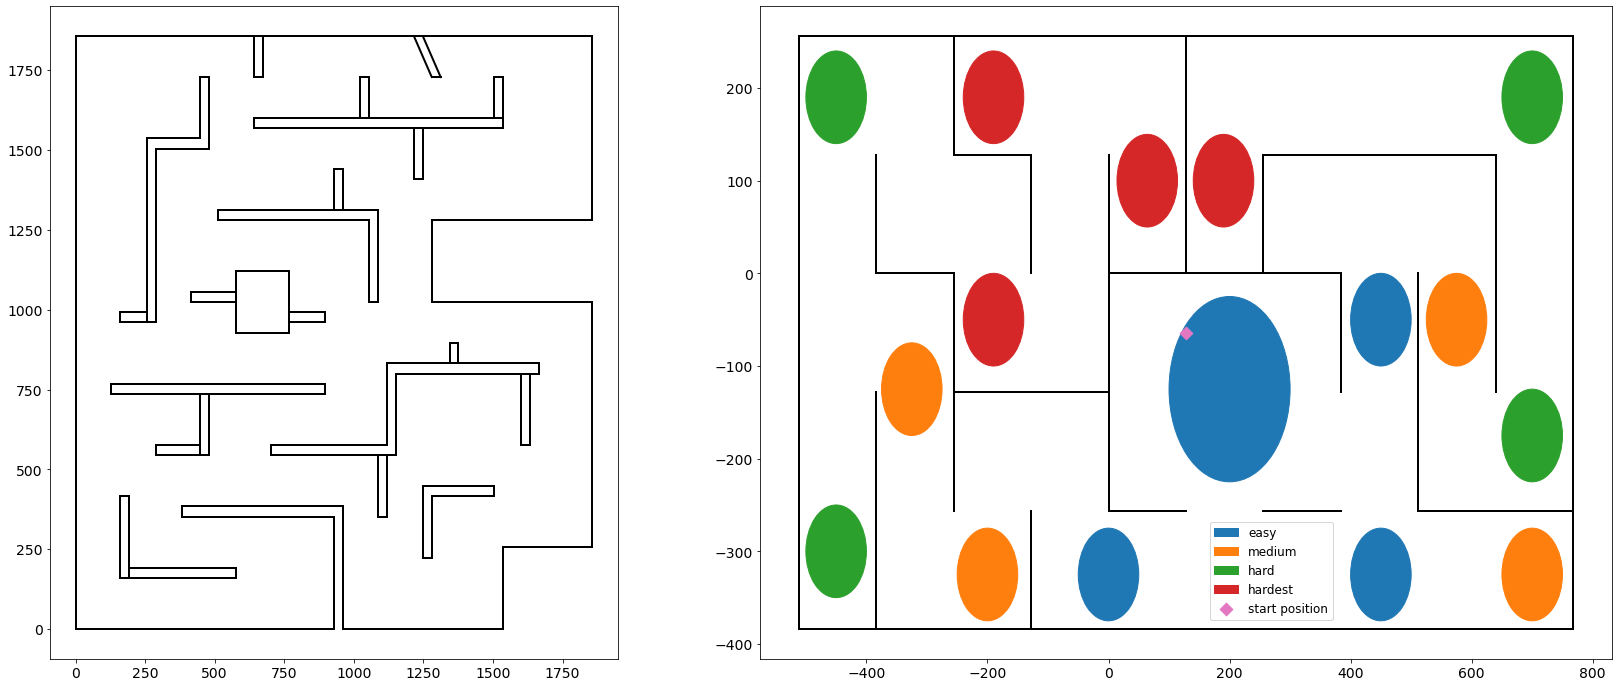

In [147]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(28, 12), gridspec_kw={'width_ratios': [1, 1.5]})
ax1.tick_params(labelsize=14)
ax2.tick_params(labelsize=14)

plot_topdown(train_env, ax1)
plot_topdown(small_env, ax2)
circles = []
for level, color in zip(levels, colors):
    goal_areas = small_goals[level]
    for goal_area in goal_areas:
        x, y, r = goal_area
        circle = plt.Circle((x, y), r, color=color, label=level, zorder=-1)
        ax2.add_artist(circle)
    circles.append(circle)
agent = ax2.scatter(*small_config['env']['start_position'][:2], s=81, color='tab:pink', marker='D', label='start position', zorder=1)
ax2.legend(handles=[*circles, agent], loc='lower center', bbox_to_anchor=(0.60, 0.05), fontsize=12)
plt.savefig('images/mazes.png', bbox_inches='tight')

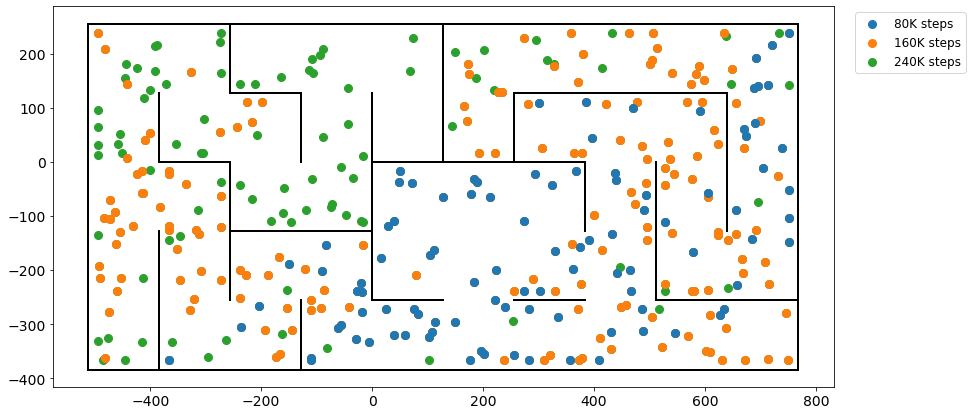

In [547]:
# plt.figure(figsize=(14, 7))

# landmarks = np.load('../data/local/20200925/vizdoom/run_6/landmarks_itr_9999.npz')
# positions = landmarks['positions']
# plot_topdown(small_env, plt)
# plt.scatter(positions[:, 0], positions[:, 1], label='80K steps', s=64, zorder=3)

# landmarks = np.load('../data/local/20200925/vizdoom/run_6/landmarks_itr_19999.npz')
# positions = landmarks['positions']
# plt.scatter(positions[:, 0], positions[:, 1], label='160K steps', s=64, zorder=2)

# landmarks = np.load('../data/local/20200925/vizdoom/run_6/landmarks_itr_29999.npz')
# positions = landmarks['positions']
# plt.scatter(positions[:, 0], positions[:, 1], label='240K steps', s=64, zorder=1)

# plt.tick_params(labelsize=14)
# plt.legend(fontsize=12, bbox_to_anchor=(1.02, 1))
# plt.savefig('images/landmark_expansion.png', bbox_inches='tight')

In [198]:
small_config['agent']['feature_model_kwargs']['fixed_weights_path'] = '../' + \
    small_config['agent']['feature_model_kwargs']['fixed_weights_path'] 

In [449]:
feature_model = FixedVizDoomModel(**small_config['agent']['feature_model_kwargs'])
feature_model.to(device)

FixedVizDoomModel(
  (encoder): Linear(in_features=1, out_features=1, bias=True)
)

In [548]:
weights = torch.load('../data/local/20200922/vizdoom/run_0/itr_249999.pkl', map_location=device)
landmarks = np.load('../data/local/20200922/vizdoom/run_0/landmarks_itr_249999.npz')

In [549]:
dsr_model = DsrModel(train_env.observation_space.shape,
                     train_env.action_space.n, **train_config['agent']['model_kwargs']).to(device)

In [550]:
dsr_model.load_state_dict(weights['agent_state_dict']['model'])
dsr_model.eval()
dsr_model.to(device)

DsrModel(
  (dsr): MlpModel(
    (model): Sequential(
      (0): Linear(in_features=2048, out_features=2048, bias=True)
      (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=2048, out_features=1024, bias=True)
      (4): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Linear(in_features=1024, out_features=14336, bias=True)
    )
  )
  (q_estimate): Linear(in_features=2048, out_features=1, bias=True)
)

In [551]:
def get_s_features(state, norm=True, numpy=True):
    features = feature_model(torch.Tensor(state).unsqueeze(0).to(device))
    s_features = dsr_model(features, mode='dsr')
    if norm:
        s_features = torch.mean(s_features, dim=1)
        s_features = s_features / torch.norm(s_features, p=2, dim=1, keepdim=True)
    if numpy:
        s_features = s_features.detach().cpu().numpy().squeeze()
    return s_features

In [552]:
positions = landmarks['positions']
N = len(positions)

dsr = landmarks['dsr']
norm_dsr = dsr / np.linalg.norm(dsr, ord=2, axis=1, keepdims=True)
dsr_sim = np.matmul(norm_dsr, norm_dsr.T)
dsr_sim[np.eye(N, dtype=bool)] = -1
features = landmarks['features']
norm_features = features / np.linalg.norm(features, ord=2, axis=1, keepdims=True)
feature_sim = np.matmul(norm_features, norm_features.T)

edge_random_steps = landmarks['edge_random_steps']
edge_random_transitions = landmarks['edge_random_transitions']
edge_subgoal_steps = landmarks['edge_subgoal_steps']
edge_subgoal_failures = landmarks['edge_subgoal_failures']
edge_subgoal_transitions = landmarks['edge_subgoal_transitions']

random_steps = edge_random_steps + np.tril(edge_random_steps, -1).T
random_transitions = edge_random_transitions + np.tril(edge_random_transitions, -1).T

subgoal_steps = edge_subgoal_steps + np.tril(edge_subgoal_steps, -1).T
subgoal_failures = edge_subgoal_failures + np.tril(edge_subgoal_failures, -1).T
subgoal_transitions = edge_subgoal_transitions + np.tril(edge_subgoal_transitions, -1).T

average_random_steps = random_steps / np.clip(random_transitions, 1, None)
average_subgoal_steps = subgoal_steps / np.clip(subgoal_transitions, 1, None)

transitions = random_transitions + subgoal_transitions

In [554]:
print('Number of landmarks:', N)
print('Number of non-zero random transitions:', np.argwhere(random_transitions > 0).shape[0])
percentile = 50
threshold = np.percentile(random_transitions[random_transitions > 0], percentile)
print('{} percentile of random transitions:'.format(percentile), 
      threshold)

temporally_nearby_threshold = max(N // 10, 10)
temporally_nearby_landmarks = np.tril(np.triu(np.ones((N), dtype=bool), 1), temporally_nearby_threshold)

subgoal_edges = np.argwhere(subgoal_transitions > 0)
print('Number of subgoal edges:', subgoal_edges.shape[0])
failure_edges = np.argwhere(subgoal_failures > 0)
print('Number of failure edges:', failure_edges.shape[0])

true_edges = random_transitions >= threshold
# true_edges = temporally_nearby_landmarks & true_edges

k = 5
nearest_neighbors = np.argpartition(true_edges * random_transitions, -k)[:, -k:]
k_filter = np.zeros((N, N), dtype=bool)
idx = np.vstack([np.arange(N)] * k).T
k_filter[idx, nearest_neighbors] = True
true_edges = k_filter & true_edges

# true_edges = (subgoal_failures <= 1) & true_edges

edge_weights = true_edges * (np.exp(-1 * random_transitions))
edge_weights[(edge_weights > 0) & (subgoal_failures > 1)] = \
    edge_weights[(edge_weights > 0) & (subgoal_failures >1)] + 5000

edges = np.argwhere(edge_weights > 0)
print('Number of edges:', edges.shape[0])

Number of landmarks: 2433
Number of non-zero random transitions: 41219
50 percentile of random transitions: 1.0
Number of subgoal edges: 8456
Number of failure edges: 2552
Number of edges: 10121


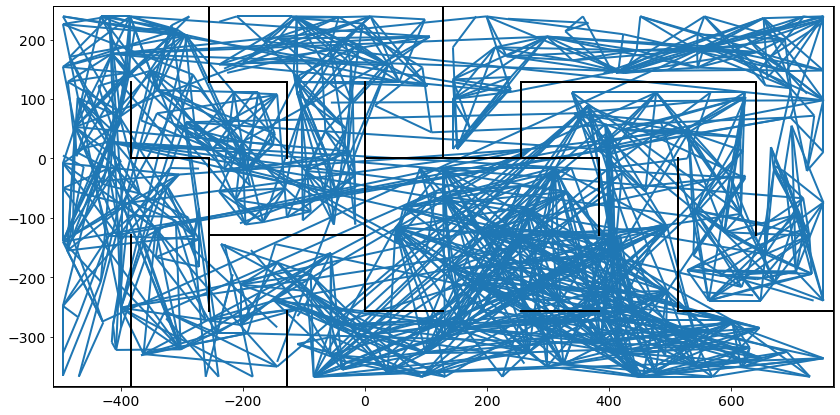

In [542]:
starts = positions[edges[:, 0], :2]
ends = positions[edges[:, 1], :2]
lc = mc.LineCollection(list(zip(starts, ends)),
                       linewidths=2)
fig, ax = plt.subplots(figsize=(14, 7))
plt.tick_params(labelsize=14)
ax.set_xlim(small_env.min_x, small_env.max_x)
ax.set_ylim(small_env.min_y, small_env.max_y)
plot_topdown(small_env, ax)
ax.add_collection(lc)
plt.savefig('images/edges-failures-temporal-landmarks.png')

In [556]:
with open('../experiments/configs/2589-small-fixed-start-goal-pairs.json') as f:
    goal_pairs = json.load(f)

with open('../experiments/configs/225-train-random-start-goal-pairs.json') as f:
    goal_pairs = json.load(f)

In [557]:
env = train_env

In [611]:
def get_path(goal_idx):
    start_pos, goal_pos = goal_pairs['easy'][goal_idx]
    start_state, start_pos = env.get_obs_at(start_pos, idx=3)
    goal_state, goal_pos = env.get_obs_at(goal_pos, idx=-1)
    start_sf = get_s_features(start_state)
    goal_sf = get_s_features(goal_state)

    start_sim = np.matmul(norm_dsr, start_sf).max()
    start_landmark = np.matmul(norm_dsr, start_sf).argmax()

    goal_sim = np.matmul(norm_dsr, goal_sf.T).max()
    goal_landmark = np.matmul(norm_dsr, goal_sf.T).argmax()

    print('SF start:', start_landmark)
    print('SF goal:', goal_landmark)
    
    graph = nx.from_numpy_array(edge_weights)
    has_path = nx.has_path(graph, start_landmark, goal_landmark)
    if has_path:
        path = nx.shortest_path(graph, start_landmark, goal_landmark, weight='weight')
        print('Found path:', path)
    else:
        print('No path from {} to {}'.format(start_landmark, goal_landmark))
    
    return start_pos, goal_pos, path

In [617]:
good_start, good_goal, good_path = get_path(11)
bad_start, bad_goal, bad_path = get_path(5)

SF start: 422
SF goal: 1400
Found path: [422, 380, 397, 466, 385, 368, 375, 389, 394, 1400]
SF start: 111
SF goal: 921
Found path: [111, 124, 31, 39, 1287, 717, 1375, 715, 598, 596, 778, 688, 675, 776, 503, 500, 643, 637, 491, 594, 375, 1352, 365, 377, 5, 216, 103, 1978, 970, 971, 6, 299, 963, 914, 339, 918, 921]


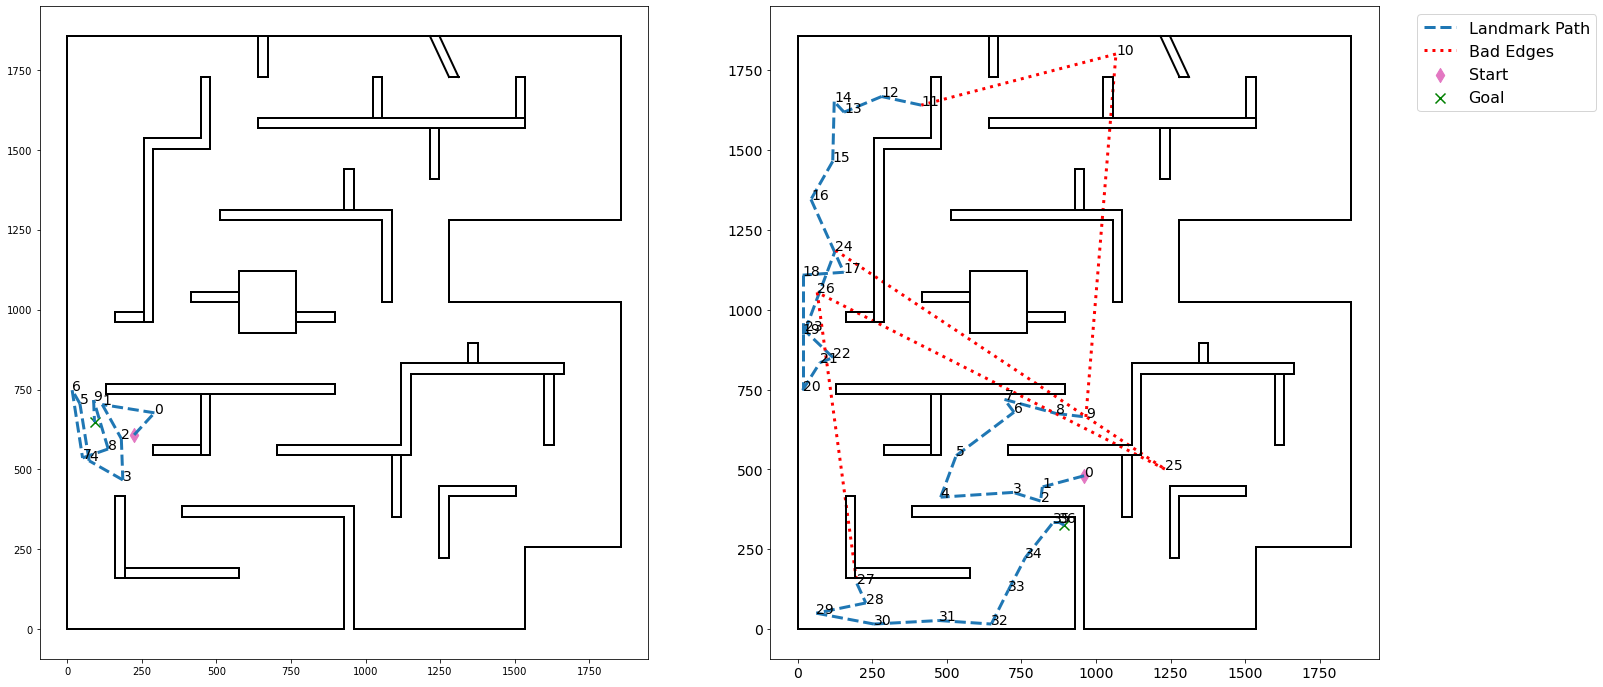

In [625]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 12))
plot_topdown(env, ax1)
for i, landmark in enumerate(good_path):
     ax1.text(*positions[landmark, :2], str(i), fontsize=14)

lines = []
full_path = [good_start[:2], *positions[good_path, :2], good_goal[:2]]
full_path = list(map(tuple, full_path))
lines = list(zip(full_path, full_path[1:]))


lc = mc.LineCollection(lines, linewidths=3, linestyle='--', label='Landmark Path')
ax1.add_collection(lc)

ax1.scatter(*good_start[:2], marker='d', s=100, color='tab:pink', label='Start')
ax1.scatter(*good_goal[:2], marker='x', s=100, color='green', label='Goal')

plot_topdown(env, ax2)
for i, landmark in enumerate(bad_path):
     ax2.text(*positions[landmark, :2], str(i), fontsize=14)

lines = []
full_path = [bad_start[:2], *positions[bad_path, :2], bad_goal[:2]]
full_path = list(map(tuple, full_path))
lines = list(zip(full_path, full_path[1:]))

bad_lines = [10, 11, 25, 26, 27]
lc = mc.LineCollection([lines[i] for i in range(len(lines)) if i not in bad_lines], 
                       linewidths=3, linestyle='--', label='Landmark Path')
ax2.add_collection(lc)
lc = mc.LineCollection([lines[i] for i in bad_lines], 
                       linewidths=3, linestyle=':', color='red', label='Bad Edges')
ax2.add_collection(lc)

ax2.scatter(*bad_start[:2], marker='d', s=100, color='tab:pink', label='Start')
ax2.scatter(*bad_goal[:2], marker='x', s=100, color='green', label='Goal')

plt.tick_params(labelsize=14)
plt.legend(fontsize=16, bbox_to_anchor=(1.05, 1))
plt.savefig('images/random-paths.png', bbox_inches='tight')